In [191]:
import utils
from utils import *
import importlib
import numpy as np
import math
import pandas as pd
import pprint
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import math, time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
import tensorflow
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Conv2D, Reshape, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, ZeroPadding2D
import time




In [189]:
def run_neural_network(X_train, y_train, X_test, y_test, subset_size=0.016):
    
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.016)
    #X_train, y_train, X_test, y_test = split_data(X_train, y_train, train_size=0.08)
    
    num_category = 10 

    y_train_oh = keras.utils.to_categorical(y_train, num_category)
    y_test_oh = keras.utils.to_categorical(y_test, num_category)

    model = keras.Sequential()
    print(X_train.shape)
    #model.add(Dense(32, input_dim=784))
    #model.add(Conv2D(32, [3, 3], activation='relu', input_shape=(X_train.shape[1],)))
    #model.add(Reshape((28, 28, 1), input_shape=(X_train.shape[1],)))
    #model.add(Conv2D(2, (2, 2), activation='relu', ))
    input_img = Input(shape=(784,))
    model.add(Dense(128, activation='relu')(input_img))
    model.add(Conv2D(4, (2, 2), activation='relu', input_shape=X_train.shape[1]))
    model.add(Conv2D(8, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(16, (2, 2), activation='relu'))
    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    # Train and fit the model:
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    history = model.fit(X_train, y_train_oh, epochs=20, verbose=1, batch_size=32,  validation_split=.1)
    loss, accuracy  = model.evaluate(X_test, y_test_oh, verbose=False)
    print(history.history)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('VGG16 accuracy MNIST')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.show()

    print('Test loss: ', loss)
    print('Test accuracy: ', accuracy)
    
    
def load_data(clean=False):
    print("loading data...")
    df_train = pd.read_csv("data/mnist/csv_format/train.csv")
    df_test = pd.read_csv("data/mnist/csv_format/test.csv")
    X = []
    y = []
    for row in df_train.iterrows() :
        label = row[1][0] # label (the number visible in the image)
        image = list(row[1][1:]) # image information as list, without label
        image = np.array(image)
        X.append(image)
        y.append(label)

    X = np.array(X)
    y = np.array(y)
    if clean:
        X = StandardScaler().fit_transform(X)
    return(X, y)

def split_data(X, y, data_size=1.0, train_size=0.8, strat=False):
    if strat:
        sss = StratifiedShuffleSplit(n_splits=1, random_state=0, train_size=train_size, test_size=train_size/4)
        for train_index, test_index in sss.split(X, y):
            print("hm")
            X_train = X[train_index]
            X_test = X[test_index]
            y_train, y_test = y[train_index], y[test_index]
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=train_size/4)
    return(X_train, y_train, X_test, y_test)

def k_means_elbow_viz(X, k_range=(2, 15)):
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=k_range)
    visualizer.fit(X)
    visualizer.show()

def k_means_silhouette(X, range_n_clusters =[2, 3, 4, 5, 6, 7, 8, 9, 10]):

    times = []
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        start_time = time.time()

        cluster_labels = clusterer.fit_predict(X)
        end_time = time.time() - start_time
        times.append(end_time)
        

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()
    
    plt.plot(range_n_clusters,times)
    plt.xlabel('n clusters')
    plt.ylabel('fit time')
    plt.title('k means fit time per # clusters')
    plt.tight_layout()
    plt.show()

def k_means_experiment(X_train, X_test, clusters):
    kmeans = KMeans(n_clusters=clusters, random_state=0)
    X_train_new = kmeans.fit_transform(X_train)
    X_test_new = kmeans.transform(X_test)
    return X_train_new, X_test_new
    
def gmm_experiment(X_train, X_test, comps):
    gmm = GMM(random_state=13, n_components=comps)
    X_train_new = gmm.fit_transform(X_train)
    X_test_new = gmm.transform(X_test)
    return X_train_new, X_test_new
    
    
def GMM_elbow(X, y, range_n_clusters=[1, 2, 3, 4, 5, 6]):
    aics = []
    bics = []
    scores = []
    times=[]
    for i in range_n_clusters:
        gmm = GMM(random_state=13, n_components=i)
        start_time = time.time()
        gmm.fit(X)
        end_time = time.time() - start_time
        times.append(end_time)
        aics.append(gmm.aic(X))
        bics.append(gmm.bic(X))
        scores.append(gmm.score(X, y))
    plt.plot(range_n_clusters, aics, label="AIC")
    plt.plot(range_n_clusters, bics, label="BIC")
    plt.xlabel ("n clusters")
    plt.ylabel ("AIC/BIC")
    plt.legend()
    plt.title ("AIC/BIC elbow method per n_clusters")
    plt.show()
    
    plt.plot(range_n_clusters,times)
    plt.xlabel('n clusters')
    plt.ylabel('fit time')
    plt.title('gmm fit time per # clusters')
    plt.tight_layout()
    plt.show()



def build_pc_col_names(num):
    col_vals = []
    for i in range(1, num+1):
        col_vals.append(i)
    return col_vals

def compare_comp_vals_PCA(X, y, vals_range=[1, 2, 3, 4, 5, 6, 7]):
    result_dfs = []
    times = []
    n_comp_vals = vals_range
    for comp_val in n_comp_vals:
        print("uh")
        pca = PCA(n_components=comp_val)
        col_vals = build_pc_col_names(comp_val)
        start_time = time.time()
        components = pca.fit_transform(X)
        end_time = time.time() - start_time
        times.append(end_time)
        pdf = pd.DataFrame(data = components
                     , columns = col_vals)
        pdy = pd.DataFrame(data=y, columns=["labels"])
        finalDf = pd.concat([pdf, pdy], axis = 1)
        result_dfs.append(finalDf)

        variance_ratio = pd.DataFrame({'var':pca.explained_variance_ratio_,
                     'PC':col_vals})
        sns.barplot(x='PC',y="var", data=variance_ratio, color="c");
        plt.show()
        plt.clf()
        plt.plot(vals_range,times)
        plt.xlabel('n clusters')
        plt.ylabel('fit time')
        plt.title('pca fit time per # components')
        plt.tight_layout()
        plt.show()
        return result_dfs

def pca_experiment(X_train, X_test, y_train, n_components, variance_thresh, visualize=True):
    pca = PCA(n_components=n_components)
    col_vals = build_pc_col_names(n_components)
    components = pca.fit_transform(X_train)
    test_components = pca.transform(X_test)
    print(X_train.shape)
    print(components.shape)

    pdf = pd.DataFrame(data = components
                 , columns = col_vals)
    pdy = pd.DataFrame(data=y_train, columns=["labels"])
    finalDf = pd.concat([pdf, pdy], axis = 1)
    variance_ratio = pd.DataFrame({'var':pca.explained_variance_ratio_,
                 'PC':col_vals})
    if visualize:
        sns.barplot(x='PC',y="var", data=variance_ratio, color="c");
        plt.show()
        plt.clf()
    cumsum = 0
    last_col_to_keep = 0
    for i in range(n_components):
        print(variance_ratio['var'][i])
        if cumsum < variance_thresh:
            print("yes")
            cumsum += variance_ratio['var'][i]
            last_col_to_keep = i
    print(components.shape)
    components_to_keep = components[:, :last_col_to_keep]
    test_components_to_keep = test_components[:, :last_col_to_keep]
    print(components_to_keep.shape)
    return(components_to_keep, test_components_to_keep)

def analyze_ICA(X, n_components, visualize=True):
    rec_err = []
    avg_kurts = []
    times = []
    best_kurt = -9999
    best_n_comp_val = 0
    comp_range = range(1, n_components, 100)
    for i in comp_range:
        print(i)
        ica = FastICA(n_components=i)
        start_time = time.time()
        ica.fit(X)
        end_time = time.time() - start_time
        times.append(end_time)
        rec_err.append(reconstructionError(ica,X))
        kurt = np.average(kurtosis(ica.components_))
        avg_kurts.append(kurt)
        if kurt > best_kurt:
            best_kurt = kurt
            best_n_comp_val = i
    if visualize:
        plt.figure(figsize=(6, 4))
        plt.plot(comp_range,avg_kurts, 'bo', comp_range,avg_kurts,'k')
        plt.xlabel('# Components')
        plt.ylabel('Avg Kurtosis')
        plt.title('ICA Kurtosis for # Components') #NM
        plt.tight_layout()
        plt.show()


        plt.figure(figsize=(6, 4))
        plt.plot(comp_range,
                 rec_err,
                 'bo',
                 comp_range,
                 rec_err,
                 'k')
        plt.xlabel('# Components')
        plt.ylabel('rec err')
        plt.title('ICA err for # Components')
        plt.tight_layout()
        plt.show()
        
        plt.plot(comp_range,times)
        plt.xlabel('n clusters')
        plt.ylabel('fit time')
        plt.title('pca fit time per # components')
        plt.tight_layout()
        plt.show()
    return best_n_comp_val, best_kurt
  

def ica_experiment(X_train, X_test, y_train, y_test, n_comps, visualize=True):
    columns_na = []
    for i in range(1, n_comps + 1):
        columns_na.append("ic " + str(i))
    transformer = FastICA(n_components=n_comps, random_state=0)
    X_transformed = transformer.fit_transform(X_train)
    #X_transformed.shape
    pdf = pd.DataFrame(data = X_transformed, columns = columns_na)
    pdy = pd.DataFrame(data=y_train, columns=['labels'])
    icaDf = pd.concat([pdf, pdy], axis = 1)
    
    X_transformed_test = transformer.transform(X_test)
    #X_transformed.shape
    pdf_test = pd.DataFrame(data = X_transformed_test, columns = columns_na)
    pdy_test = pd.DataFrame(data=y_test, columns=['labels'])
    icaDf_test = pd.concat([pdf, pdy], axis = 1)
    
    if visualize:
        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(1,1,1)
        ax.set_xlabel('ic 1', fontsize = 15)
        ax.set_ylabel('ic 2', fontsize = 15)
        ax.set_title('ICA', fontsize = 20)
        targets = [0, 1]
        colors = ['r', 'g']
        for target, color in zip(targets,colors):
            points_in_label = icaDf['labels'] == target
            ax.scatter(icaDf.loc[points_in_label, 'ic 1']
                       , icaDf.loc[points_in_label, 'ic 2']
                       , c = color
                       , s = 50)
        ax.legend(targets)
        ax.grid()

        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('ic 1', fontsize = 15)
        ax.set_ylabel('ic 2', fontsize = 15)
        ax.set_zlabel('ic 3', fontsize = 15)
        ax.set_title('ICA', fontsize = 20)
        targets = [0, 1]
        colors = ['g', 'r']
        for target, color in zip(targets,colors):
            points_in_label = icaDf['labels'] == target
            ax.scatter(icaDf.loc[points_in_label, 'ic 1']
                       , icaDf.loc[points_in_label, 'ic 2']
                       , icaDf.loc[points_in_label, 'ic 3']
                       , c = color
                       , s = 50)
        ax.legend(targets)
        #ax.set_ylim(-1, 1)
        ax.grid()

    return icaDf, icaDf_test

def run_PCA(X,y,title):

    pca = PCA(random_state=5).fit(X) #for all components
    cum_var = np.cumsum(pca.explained_variance_ratio_)

    fig, ax1 = plt.subplots()
    ax1.plot(list(range(len(pca.explained_variance_ratio_))), cum_var, 'b-')
    ax1.set_xlabel('Principal Components')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Cumulative Explained Variance Ratio', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(list(range(len(pca.singular_values_))), pca.singular_values_, 'm-')
    ax2.set_ylabel('Eigenvalues', color='m')
    ax2.tick_params('y', colors='m')
    plt.grid(False)

    plt.title("PCA Explained Variance and Eigenvalues: "+ title)
    fig.tight_layout()
    plt.show()

def run_ICA(X,y,title): #when kurtosis high, components less gaussian, more independent

    dims = list(np.arange(2,(X.shape[1]-1),3))
    #dims = list(np.arange(2,80,3))
    dims.append(X.shape[1])
    ica = FastICA(random_state=5)
    kurt = []

    for dim in dims:
        print(dim)
        ica.set_params(n_components=dim)
        tmp = ica.fit_transform(X)
        tmp = pd.DataFrame(tmp)
        tmp = tmp.kurt(axis=0)
        kurt.append(tmp.abs().mean())

    plt.figure()
    plt.title("ICA Kurtosis: "+ title)
    plt.xlabel("Independent Components")
    plt.ylabel("Avg Kurtosis Across IC")
    plt.plot(dims, kurt, 'b-')
    plt.grid(False)
    plt.show()

def run_SparseRandomProjection(X,title):

    dims = list(np.arange(2,(X.shape[1]-1),100))
    print(dims)
    dims.append(X.shape[1])
    tmp = defaultdict(dict)
    for i,dim in product(range(5),dims):
        print(i)
        rp = SparseRandomProjection(random_state=i, n_components=dim)
        tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(X), X)
    tmp = pd.DataFrame(tmp).T
    mean_recon = tmp.mean(axis=1).tolist()
    std_recon = tmp.std(axis=1).tolist()


    fig, ax1 = plt.subplots()
    ax1.plot(dims,mean_recon, 'b-')
    ax1.set_xlabel('Random Components')
    ax1.set_ylabel('Mean Reconstruction Correlation', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(dims,std_recon, 'm-')
    ax2.set_ylabel('STD Reconstruction Correlation', color='m')
    ax2.tick_params('y', colors='m')
    plt.grid(False)

    plt.title("Random Components for 5 Restarts: "+ title)
    fig.tight_layout()
    plt.show()

def RP_experiment(X_train, X_test, n_comps, visualize=True):
    rp = SparseRandomProjection(n_components=n_comps)
    X_train_new = rp.fit_transform(X_train)
    X_test_new = rp.transform(X_test)
    return(X_train_new, X_test_new)

def RFC_experiment(X_train, X_test, y, threshold=0.8, visualize=True):
    #print(X)
    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()
    rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
    rnd_clf.fit(X_train, y)
    indices = np.argsort(-(rnd_clf.feature_importances_))
    cumsum = 0
    useful_cols = []
    useful_indices = []
    i = 0
    while cumsum < threshold:
        print(rnd_clf.feature_importances_[indices[i]])
        cumsum += rnd_clf.feature_importances_[indices[i]]
        #print(cumsum)
        useful_indices.append(indices[i])
        i+=1

    #for column, idx in zip(df.columns[:-1], x_indices):
    #    if column in useful_cols:
    #        useful_indices.append(idx)
    #print("hm ",useful_indices)
    print(X_train_copy.shape)
    X_train_copy = X_train_copy[:, useful_indices]
    X_test_copy = X_test_copy[:, useful_indices]
    print(X_train_copy.shape)
    print("X shape")
    if visualize:
        plt.title('Feature Importances')
        plt.barh(range(len(indices)), rnd_clf.feature_importances_[indices], color='b', align='center')
        #plt.yticks(range(len(indices)), [i for i in rnd_clf.feature_importances_[indices]])
        plt.xlabel('Relative Importance')
        plt.xlabel('Sorted attr by importancce')
        plt.show()
    return(X_train_copy, X_test_copy)



def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]

    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

def reconstructionError(projections,X):
    W = projections.components_
    if sps.issparse(W):
        W = W.todense()
    p = pinv(W)
    reconstructed = ((p@W)@(X.T)).T
    errors = np.square(X-reconstructed)
    return np.nanmean(errors)

In [109]:
X, y = load_data(clean=True)
#X, X_test, y, y_test = train_test_split(X, y, test_size=0.016)

loading data...


In [110]:
print(X.shape)
print(y.shape)

(42000, 784)
(42000,)


In [111]:
X_train, y_train, X_test, y_test =split_data(X, y, data_size=1.0, 
                                             train_size=0.08, strat=False)

In [112]:
print(X_train.shape)
print(y_train.shape)

(3360, 784)
(3360,)


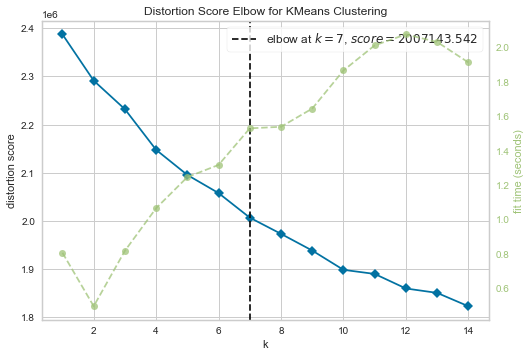

In [113]:
range_tpl = tuple(range(1, 15))
k_means_elbow_viz(X_train, k_range=range_tpl)

For n_clusters = 2 The average silhouette_score is : 0.1384742442593658
For n_clusters = 3 The average silhouette_score is : 0.04636930069364703
For n_clusters = 4 The average silhouette_score is : 0.03427915686710778
For n_clusters = 5 The average silhouette_score is : 0.03968055273163313
For n_clusters = 6 The average silhouette_score is : 0.005785593250422219
For n_clusters = 7 The average silhouette_score is : 0.0029030545918431435
For n_clusters = 8 The average silhouette_score is : -0.00014450521157132896
For n_clusters = 9 The average silhouette_score is : 0.00300519068975927
For n_clusters = 10 The average silhouette_score is : 0.0010880072176064329


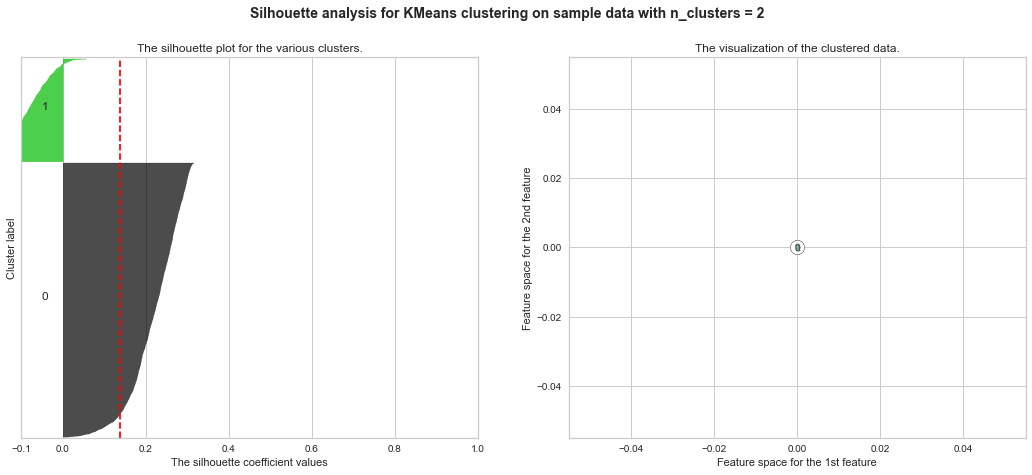

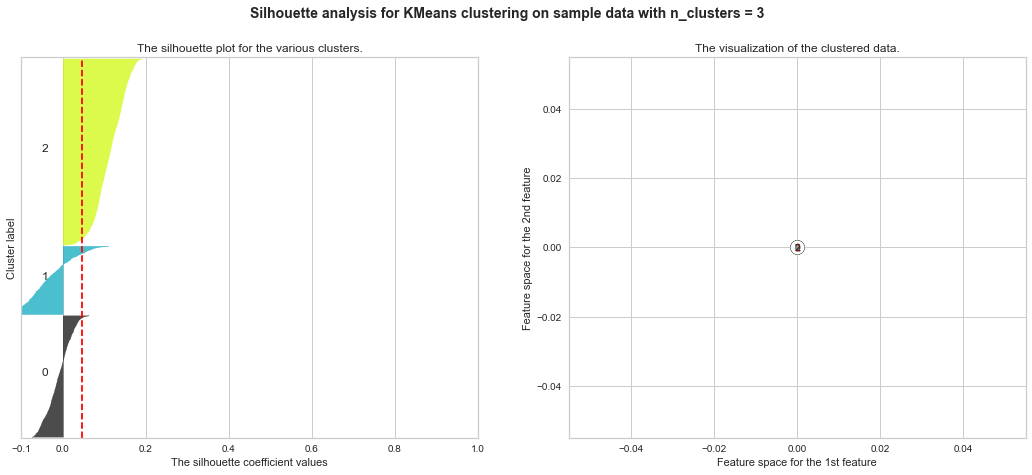

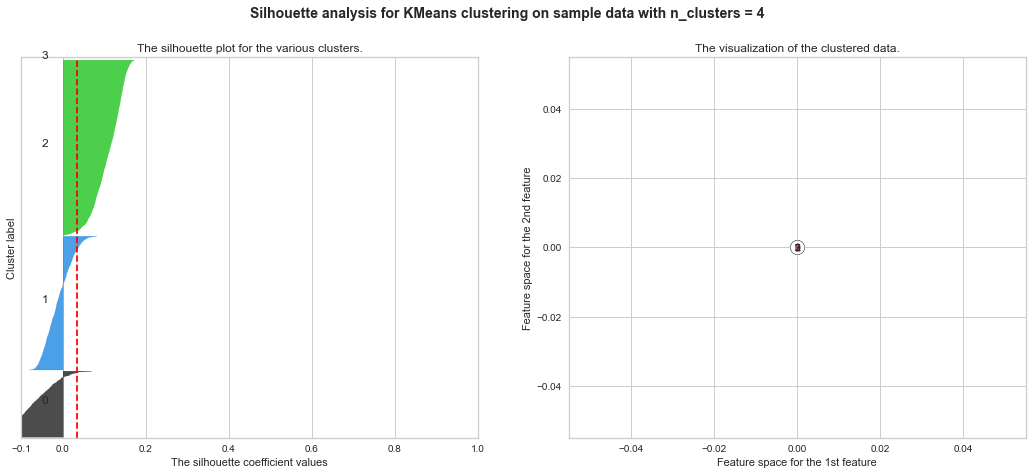

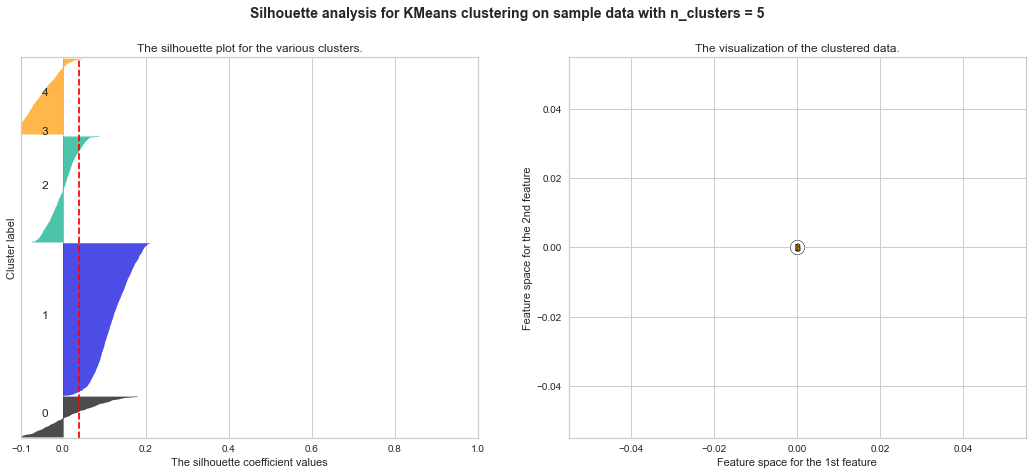

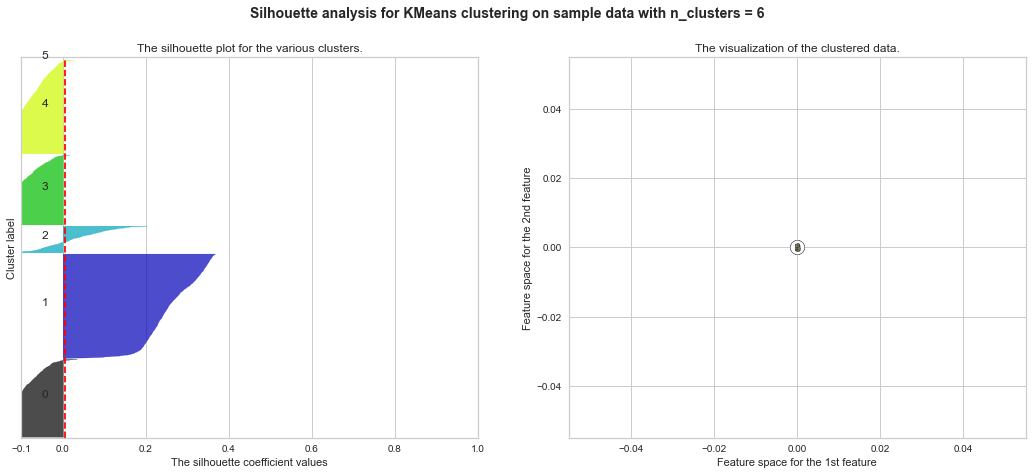

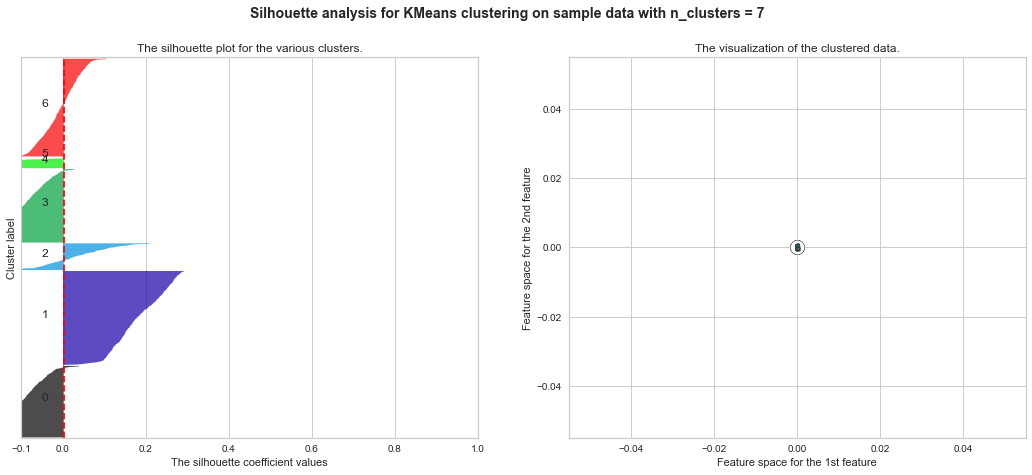

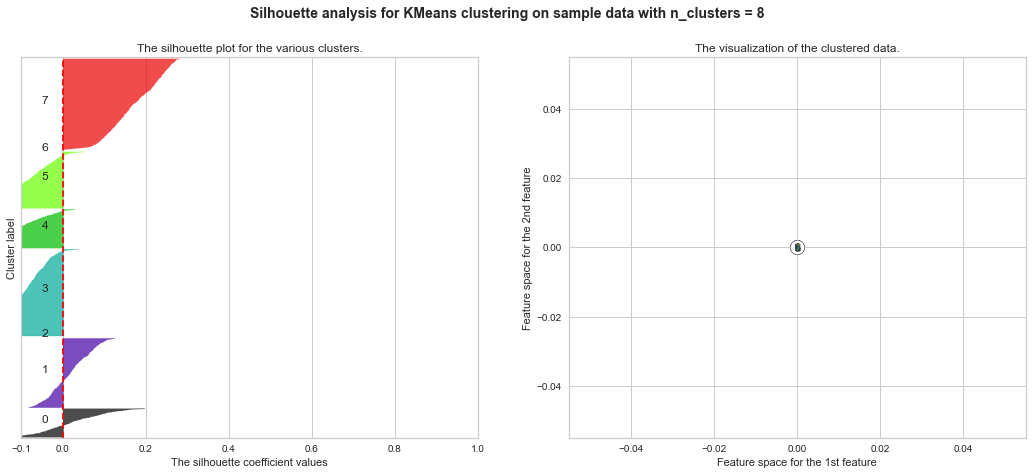

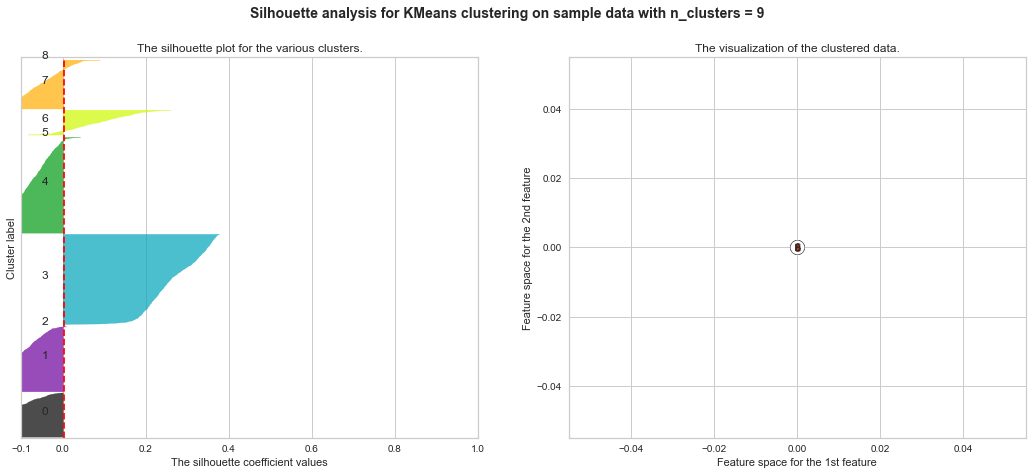

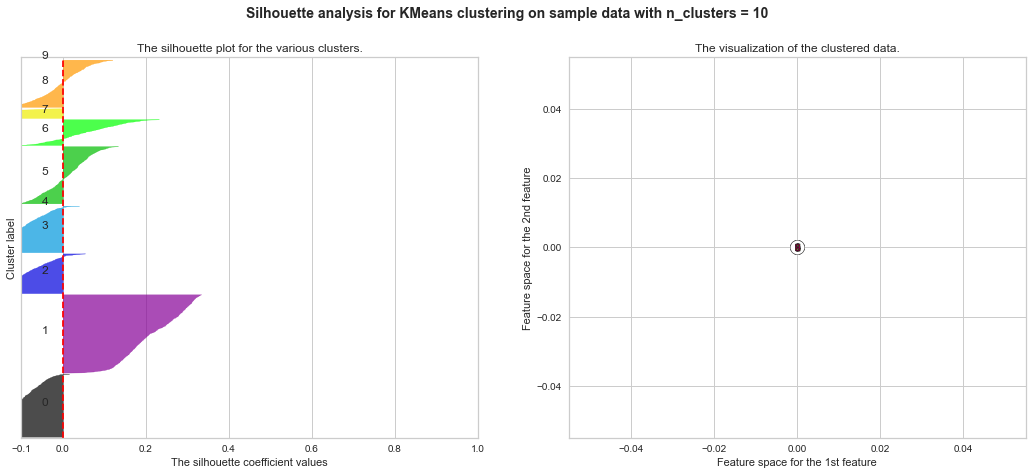

In [116]:
k_means_silhouette(X_train)

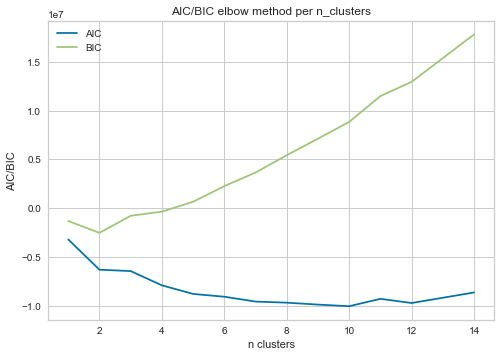

In [117]:
GMM_elbow(X_train, y_train, range_n_clusters=range(1, 15))

In [118]:
kmeans_X_train, kmeans_X_test = k_means_experiment(X_train, X_test, 6)
gmm_X_train, gmm_X_test = k_means_experiment(X_train, X_test, 6)


# PCA

(3360, 784)
(3360, 784)


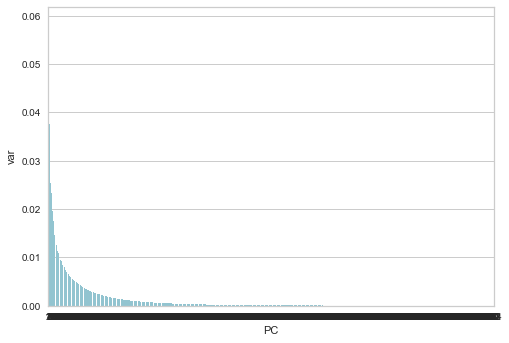

0.058912561916416424
yes
0.04321092877739687
yes
0.03879591412968134
yes
0.037692081628913174
yes
0.0295860602909684
yes
0.02534814747294383
yes
0.02334683302892513
yes
0.02277415545434516
yes
0.019632939964214214
yes
0.018628288921098957
yes
0.01746443368180375
yes
0.015851811688308688
yes
0.01458834131480457
yes
0.014350092586077777
yes
0.013279120311371096
yes
0.012612387629384476
yes
0.01206482375519889
yes
0.011410977495439938
yes
0.011190313129455043
yes
0.010850802135992847
yes
0.010554685718080816
yes
0.010155500331334173
yes
0.009526418819213477
yes
0.009466046075210973
yes
0.009295886403247407
yes
0.008420760561243294
yes
0.008364637278553624
yes
0.008288066680437982
yes
0.008026717854146938
yes
0.007940279400721626
yes
0.007635006100886842
yes
0.007496207103450234
yes
0.007230841767417947
yes
0.006941453628080242
yes
0.0067703406926288
yes
0.006645643117285413
yes
0.006507705274319061
yes
0.0063341661977332556
yes
0.0062300360607772005
yes
0.006035836288411725
yes
0.00593154

<Figure size 576x396 with 0 Axes>

In [119]:
pca_X_train, pca_X_test = pca_experiment(X_train, X_test,  y_train, 784, 0.95)

In [120]:
print(pca_X_train.shape)
print(pca_X_test.shape)

(3360, 228)
(840, 228)


# ICA

1
101
201
301
401


c:\users\fuers\anaconda3\envs\ml\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


501


c:\users\fuers\anaconda3\envs\ml\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


601


c:\users\fuers\anaconda3\envs\ml\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


701


c:\users\fuers\anaconda3\envs\ml\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


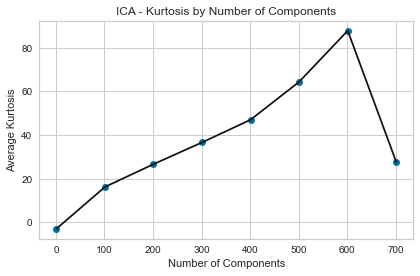

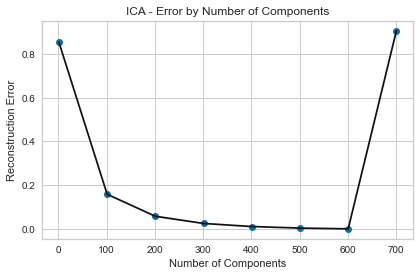

601


TypeError: ica_experiment() missing 1 required positional argument: 'n_comps'

In [121]:
best_n_comp_val, best_kurt = analyze_ICA(X_train, 784)
print(best_n_comp_val)


c:\users\fuers\anaconda3\envs\ml\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


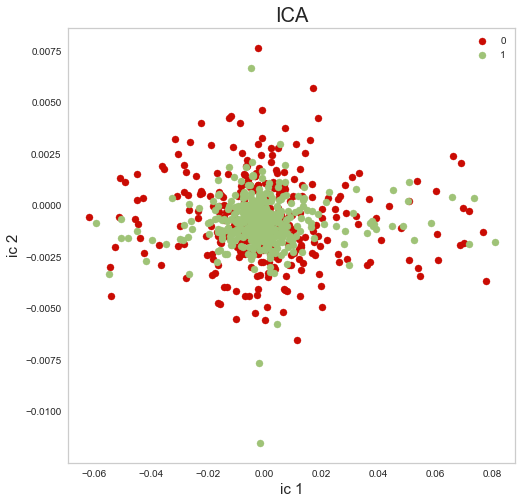

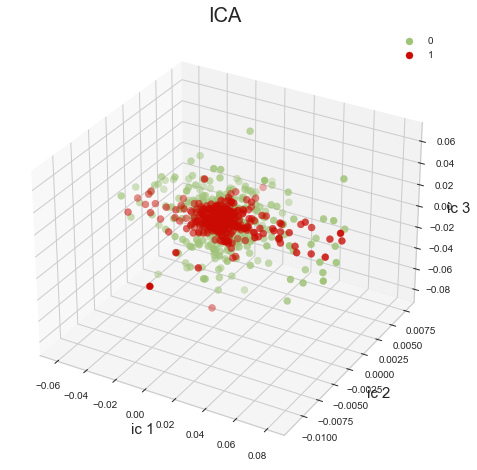

In [122]:
ica_X_train, ica_X_test = ica_experiment(X_train, X_test, y_train, y_test, best_n_comp_val)

# RP

[2, 102, 202, 302, 402, 502, 602, 702]
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4


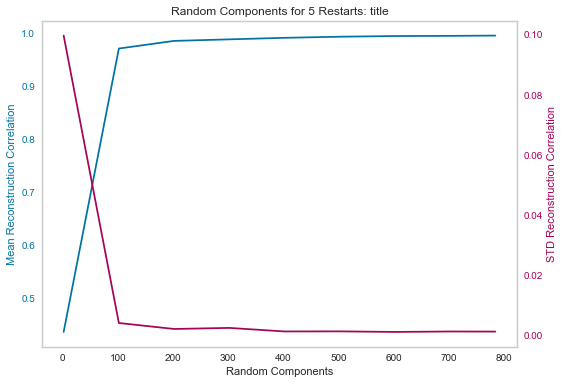

In [124]:
run_SparseRandomProjection(X_train,"title")
RP_X_train, RP_X_test = RP_experiment(X_train, X_test, 600)

# RFC

In [125]:
#data_directory = "data/"
#filename = "diabetes.csv"
#df = pd.read_csv(data_directory + filename)

'\ndef RFC_experiment(X, y, threshold=0.8, visualize=True):\n    #print(X)\n    X_copy = X.copy()\n    rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)\n    rnd_clf.fit(X, y)\n    #print(rnd_clf.feature_importances_)\n    #zipped = zip(df.columns[:-1], rnd_clf.feature_importances_)\n    #for name, importance in zipped:\n    #    print(name, "=", importance)\n    #zipped = list(zip(df.columns[:-1], rnd_clf.feature_importances_))\n    #print(zipped)\n    #res = sorted(zipped, key = lambda x: x[1], reverse=True)\n    #print(res)\n\n    indices = np.argsort(-(rnd_clf.feature_importances_))\n    print(indices.shape)\n    #indices = indices[:100]\n    print(indices.shape)\n    \n    #print(indices)\n    \n    cumsum = 0\n    useful_cols = []\n    useful_indices = []\n    i = 0\n    while cumsum < threshold:\n        print(rnd_clf.feature_importances_[indices[i]])\n        cumsum += rnd_clf.feature_importances_[indices[i]]\n        #print(cumsum)\n        useful_

0.009891992748631543
0.008379129522600975
0.007704440892399804
0.007278201841923936
0.007244303411837504
0.0072109823975040795
0.006889978819594248
0.006636181327308124
0.006607108309811502
0.006483970575612258
0.00641202669982886
0.006199797924680616
0.006178306806059166
0.0061241533263991154
0.00603377633485891
0.006018731478711129
0.006015369536806972
0.005839308828454847
0.005749411185071561
0.005699879537778833
0.00562440801705402
0.005580720992946639
0.0055674765953978534
0.005556450604802997
0.00555232216922003
0.005528244827483967
0.005486667063930942
0.005486191803948297
0.005465099219252892
0.005437827381692898
0.005423506525968934
0.005394691451887813
0.005283233317762468
0.005215962797411844
0.005209742339776438
0.005156291186172955
0.005128564386480635
0.0051248210177797385
0.005114776561602273
0.00509770800514379
0.00507612067658961
0.005059126405757395
0.005056678037283409
0.0050510142017253625
0.004987068076105747
0.004986024783059784
0.0049240051739732685
0.00491446112

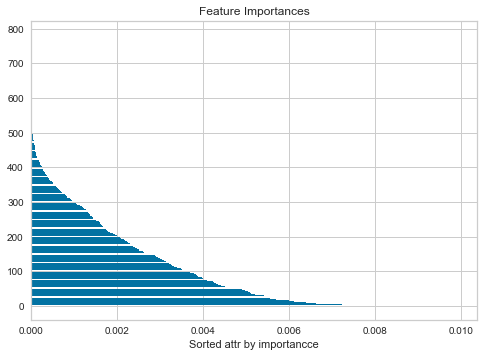

In [131]:
#indices = range(0,len(df.columns[:-1]))
#print(indices)
#RFC_X = RFC_experiment(X_train, y_train, df.columns[:-1], x_indices=indices)
RFC_X_train, RFC_X_test = RFC_experiment(X_train, X_test, y_train)

In [132]:
print(pca_X_train.shape)
print(ica_X_train.shape)
print(RP_X_train.shape)
print(RFC_X_train.shape)

print(pca_X_test.shape)
print(ica_X_test.shape)
print(RP_X_test.shape)
print(RFC_X_test.shape)

(3360, 228)
(3360, 602)
(3360, 600)
(3360, 212)
(840, 228)
(3360, 602)
(840, 600)
(840, 212)


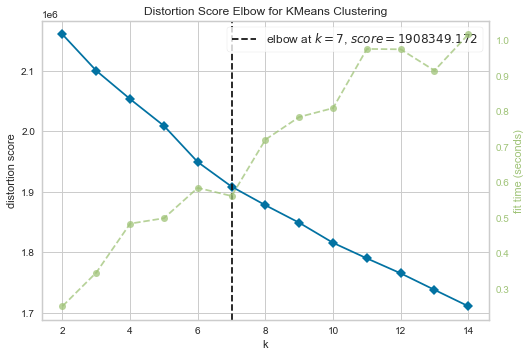

For n_clusters = 2 The average silhouette_score is : 0.12672281405259656
For n_clusters = 3 The average silhouette_score is : 0.13168319785064014
For n_clusters = 4 The average silhouette_score is : 0.06696097963977965
For n_clusters = 5 The average silhouette_score is : 0.032627453916757095
For n_clusters = 6 The average silhouette_score is : 0.009971821211389386
For n_clusters = 7 The average silhouette_score is : 0.0038842664009922042
For n_clusters = 8 The average silhouette_score is : 0.025896811296615335
For n_clusters = 9 The average silhouette_score is : 0.02338064509505185
For n_clusters = 10 The average silhouette_score is : 0.023396844410805383


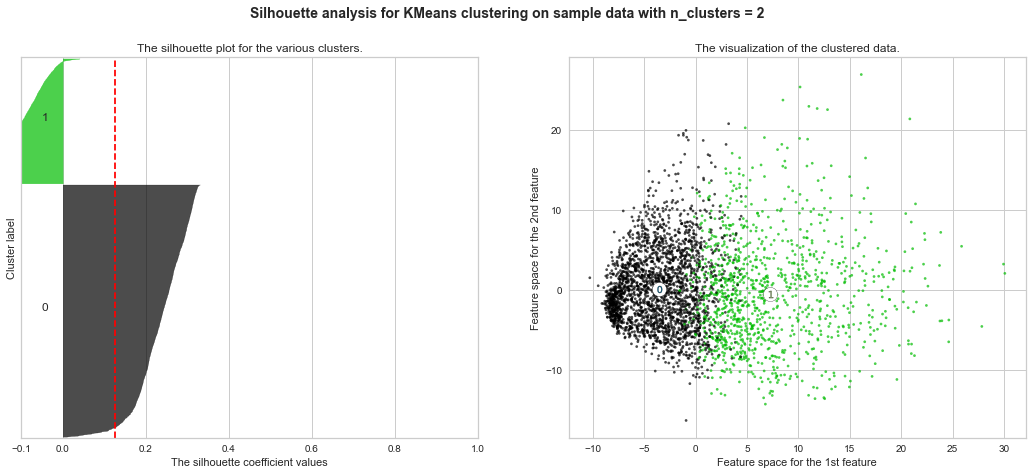

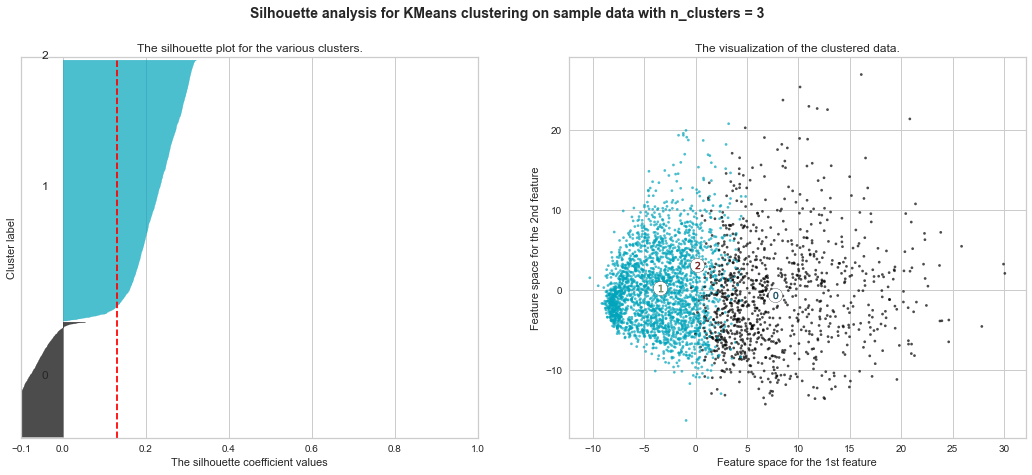

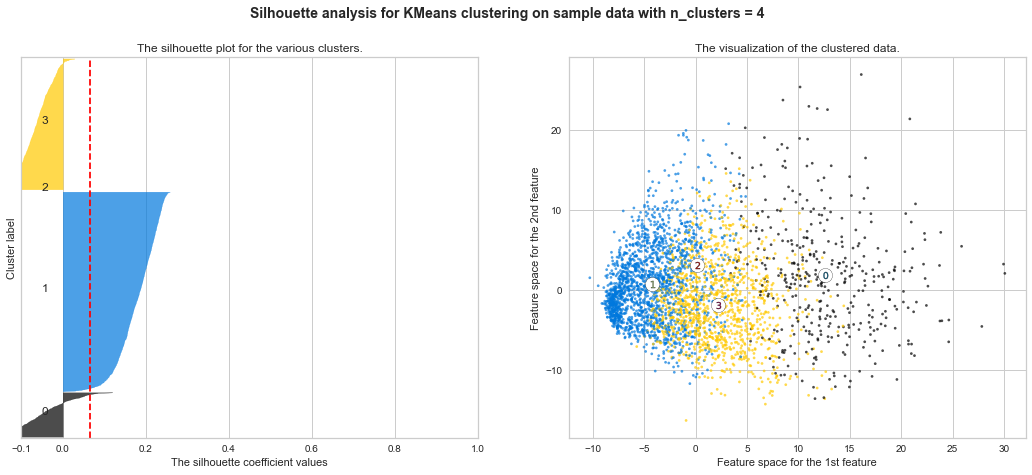

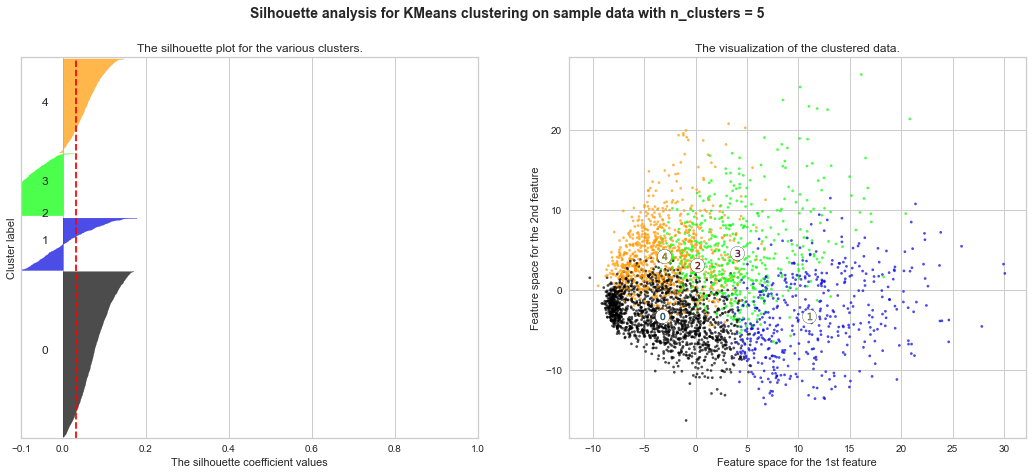

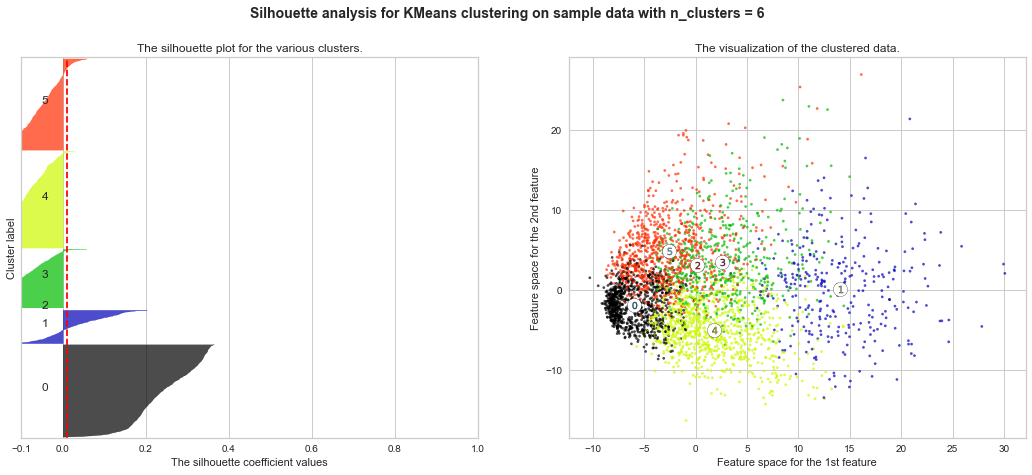

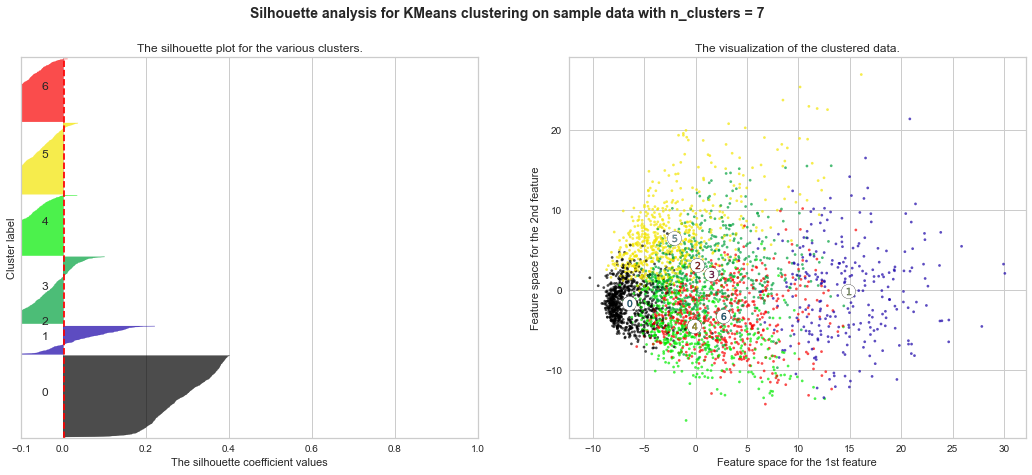

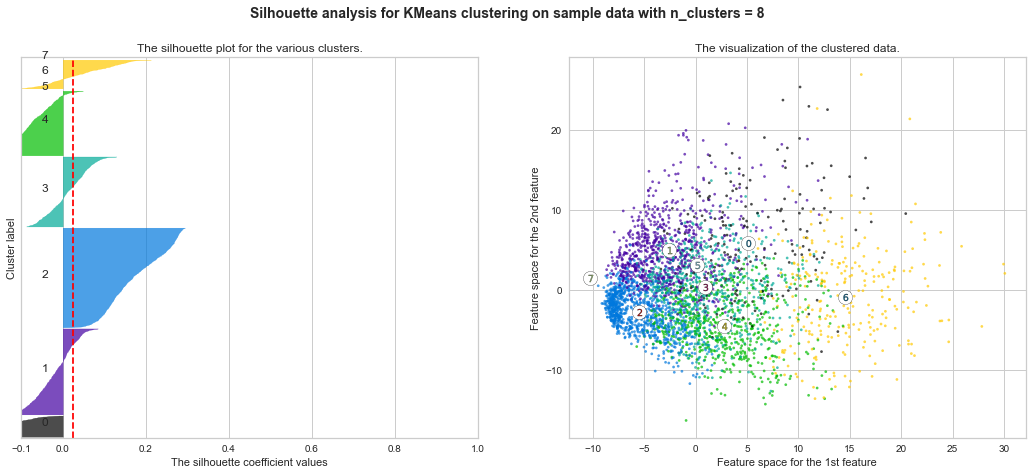

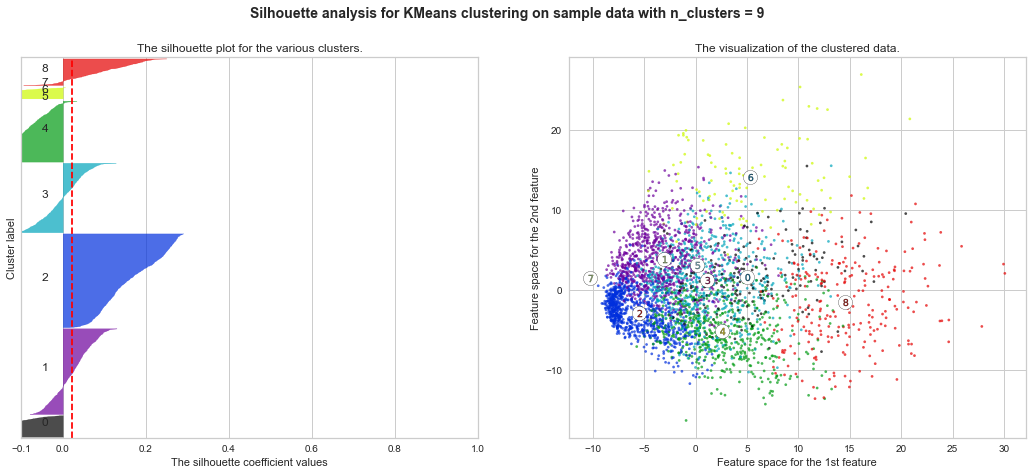

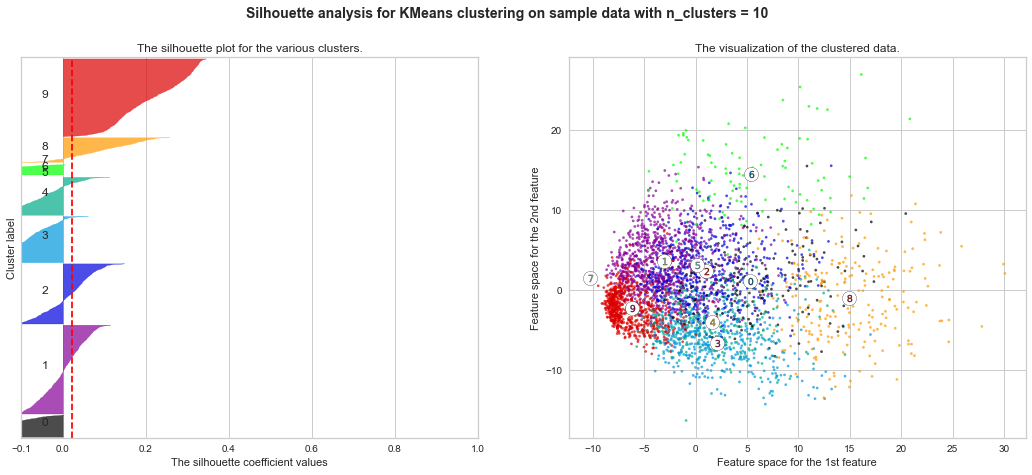

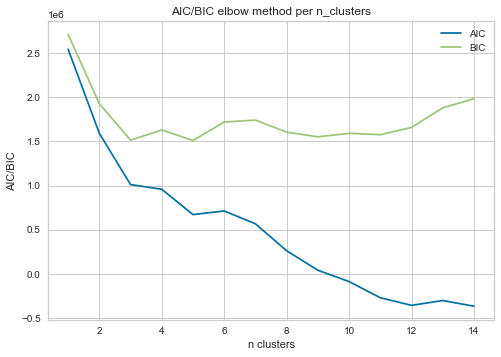

In [27]:
k_means_elbow_viz(pca_X)
k_means_silhouette(pca_X)
GMM_elbow(pca_X, y_train, range_n_clusters=range(1, 15))

(3360, 602)


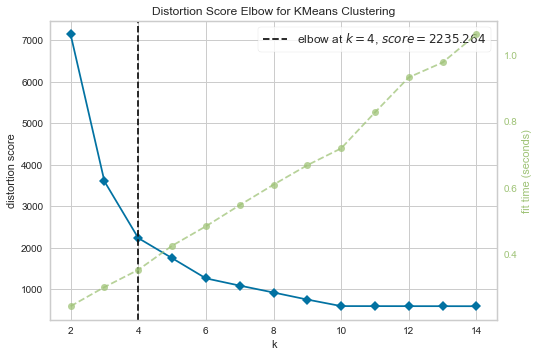

For n_clusters = 2 The average silhouette_score is : 0.6145421148284195
For n_clusters = 3 The average silhouette_score is : 0.5490683956873578
For n_clusters = 4 The average silhouette_score is : 0.5113050553558155
For n_clusters = 5 The average silhouette_score is : 0.5049472348874604
For n_clusters = 6 The average silhouette_score is : 0.4522449880174524
For n_clusters = 7 The average silhouette_score is : 0.4505319335718154
For n_clusters = 8 The average silhouette_score is : 0.45299382485389794
For n_clusters = 9 The average silhouette_score is : 0.46098608625982795
For n_clusters = 10 The average silhouette_score is : 0.5040470416358152


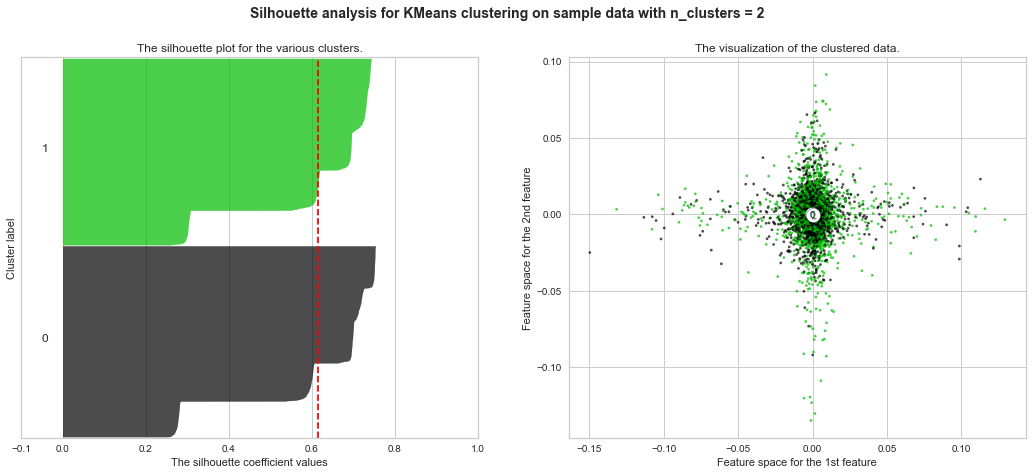

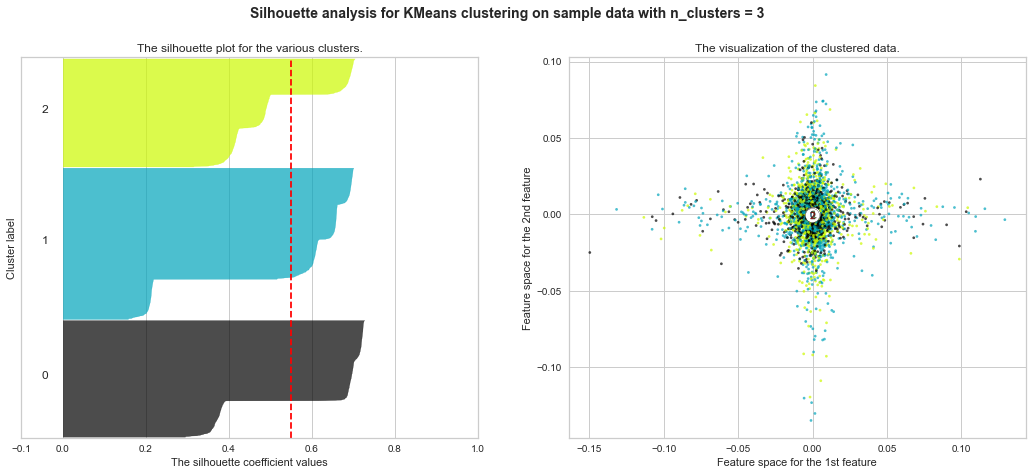

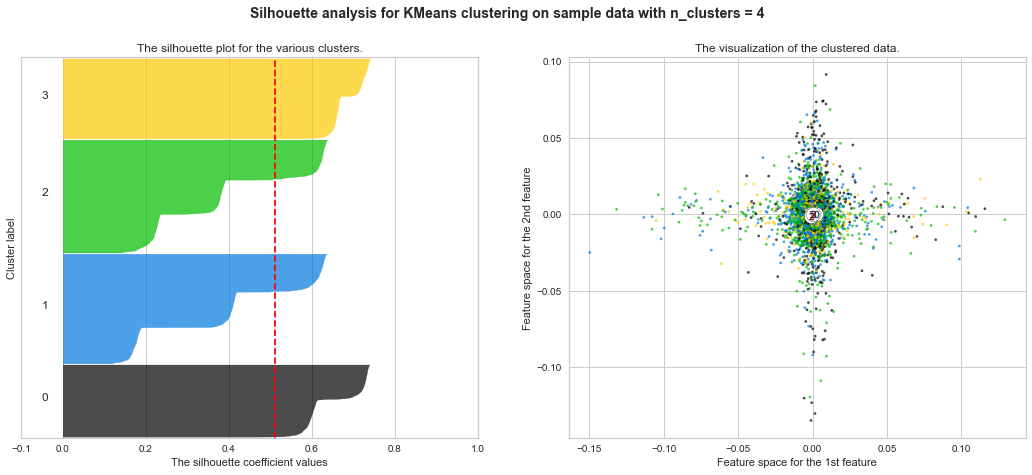

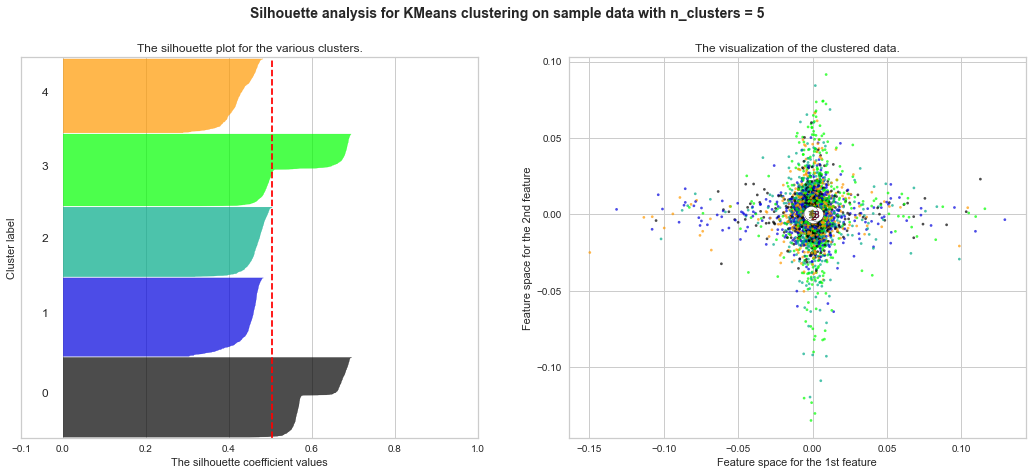

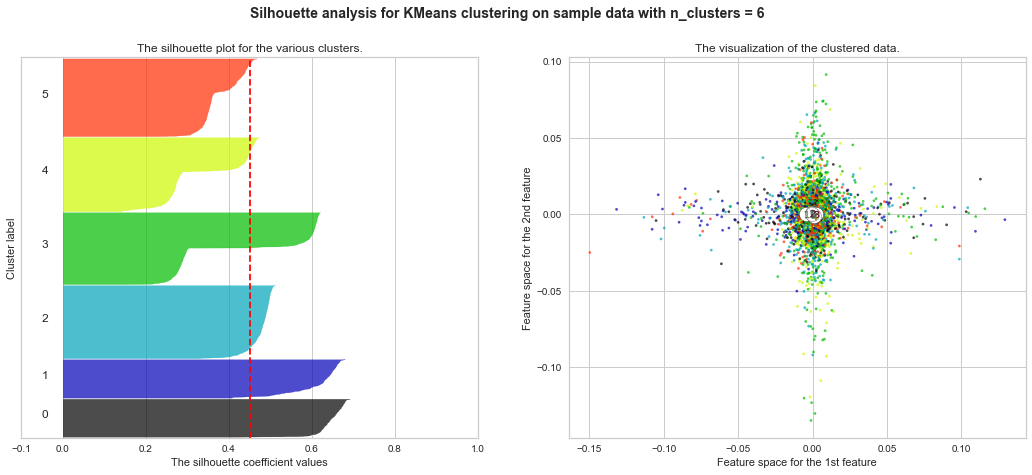

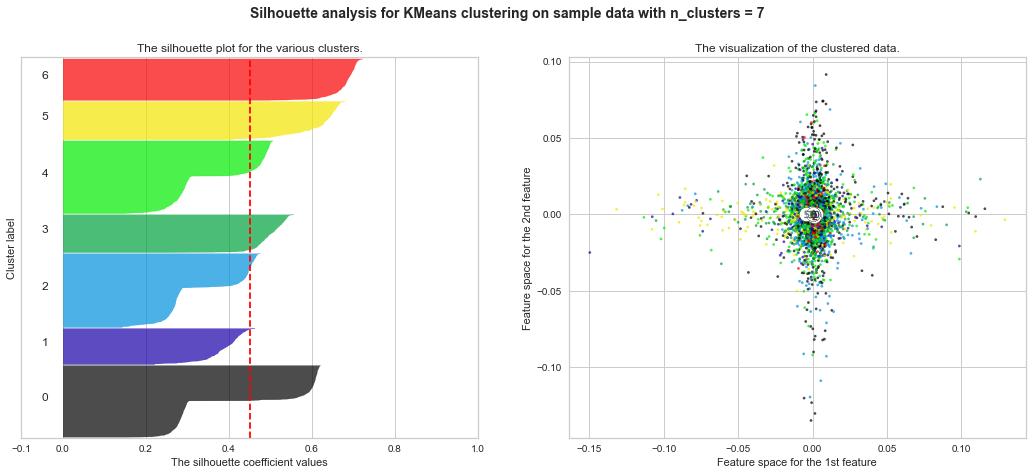

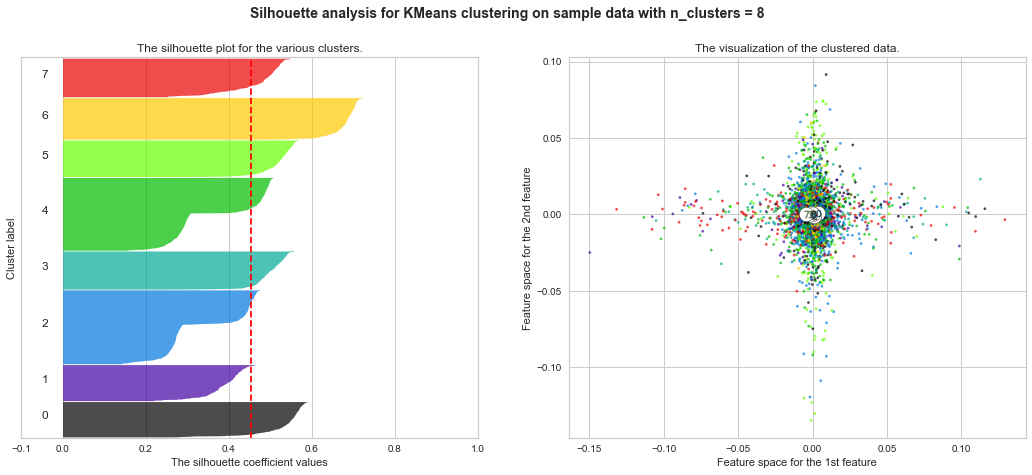

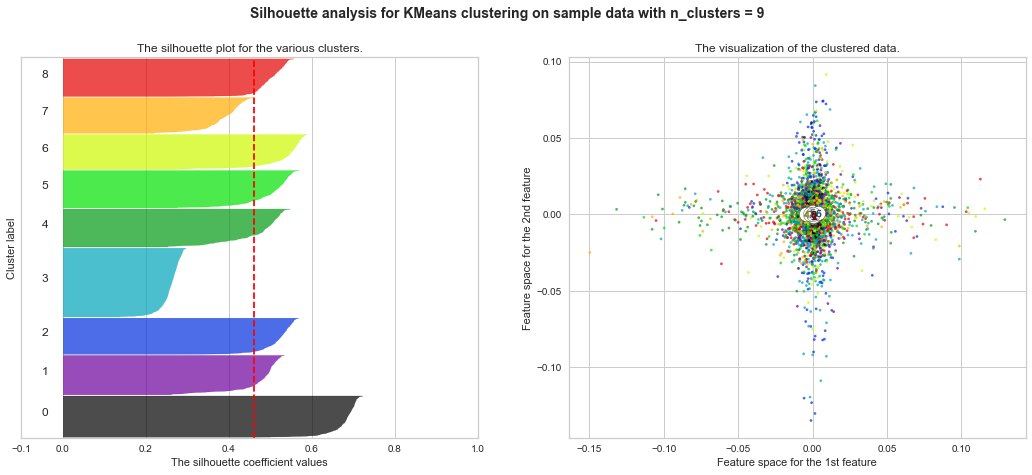

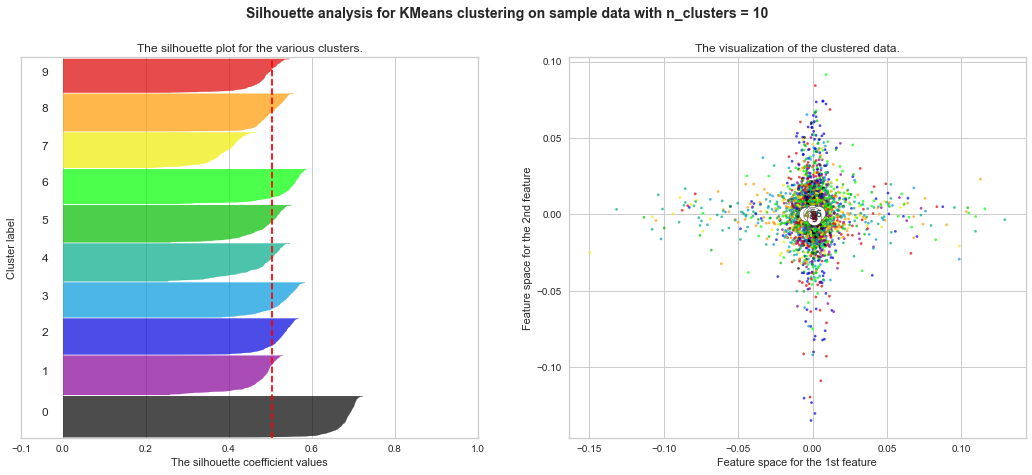

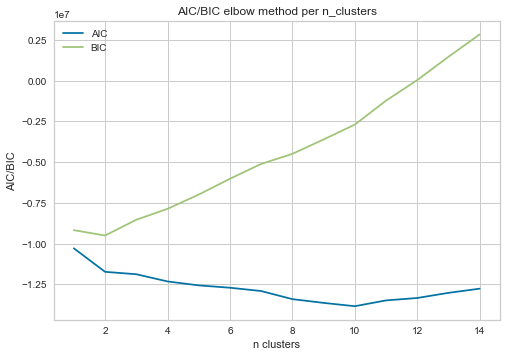

In [31]:
print(ica_X.shape)
k_means_elbow_viz(ica_X)
k_means_silhouette(ica_X)
GMM_elbow(ica_X, y_train, range_n_clusters=range(1, 15))

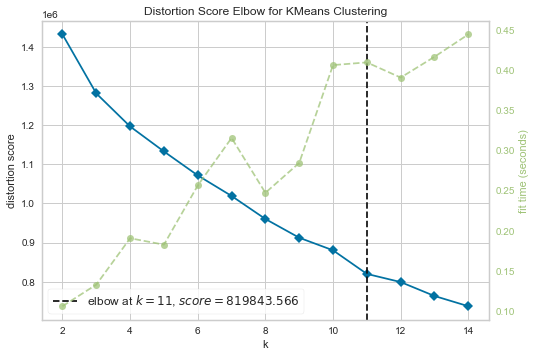

For n_clusters = 2 The average silhouette_score is : 0.21406458683628163
For n_clusters = 3 The average silhouette_score is : 0.18034661331187749
For n_clusters = 4 The average silhouette_score is : 0.14420150538099505
For n_clusters = 5 The average silhouette_score is : 0.1446373271248195
For n_clusters = 6 The average silhouette_score is : 0.1434504182287767
For n_clusters = 7 The average silhouette_score is : 0.14630020763198515
For n_clusters = 8 The average silhouette_score is : 0.1412918613052987
For n_clusters = 9 The average silhouette_score is : 0.1430604076398245
For n_clusters = 10 The average silhouette_score is : 0.14108488584905207


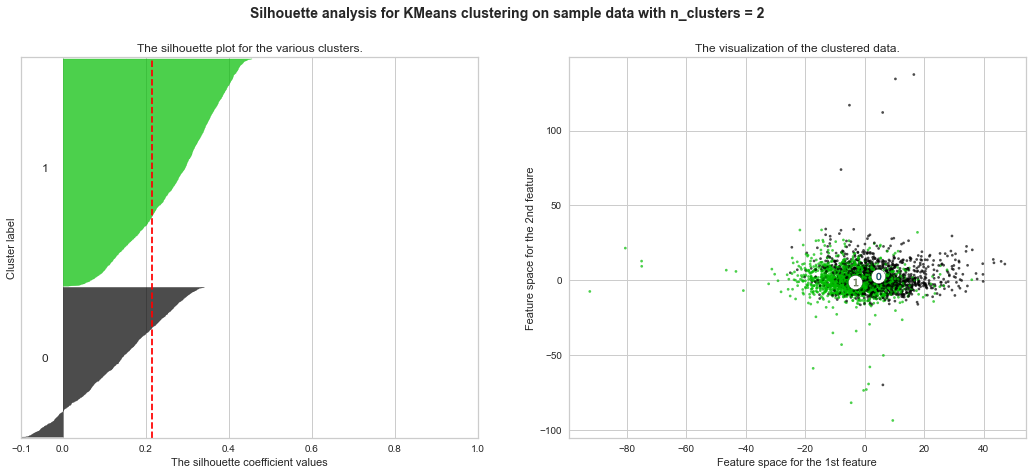

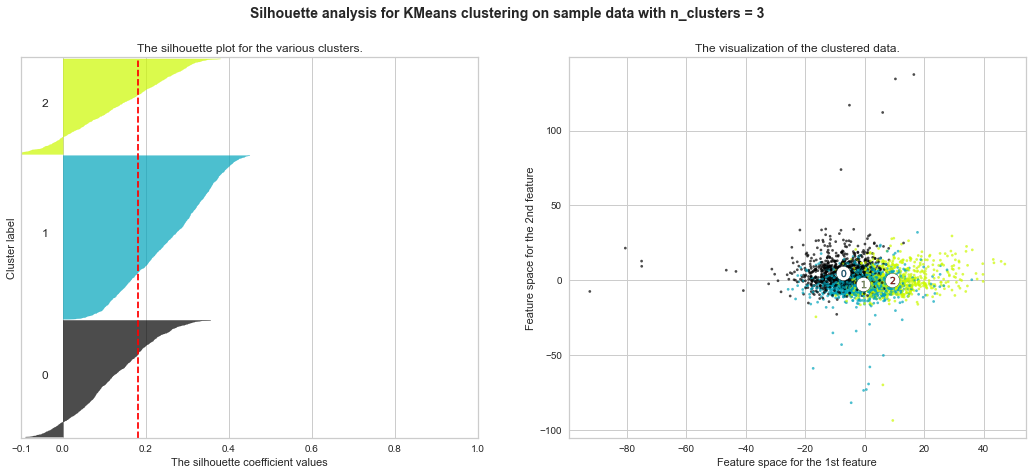

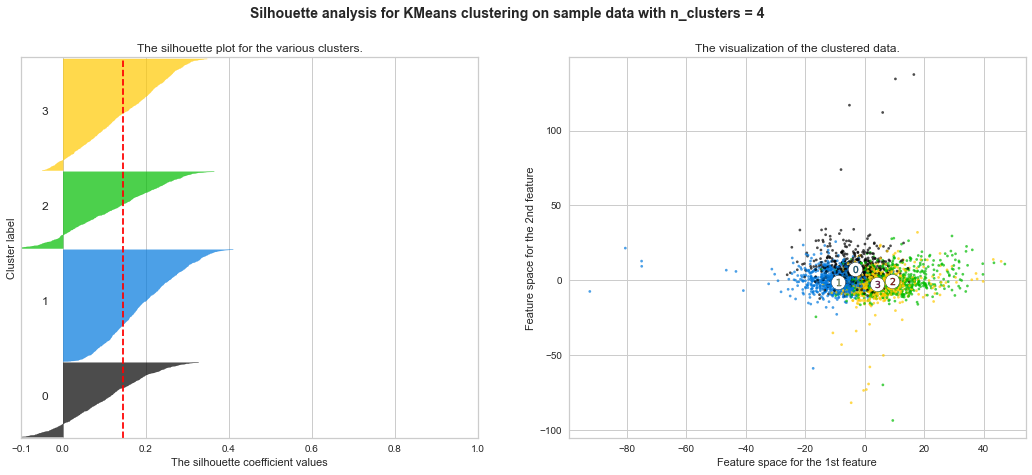

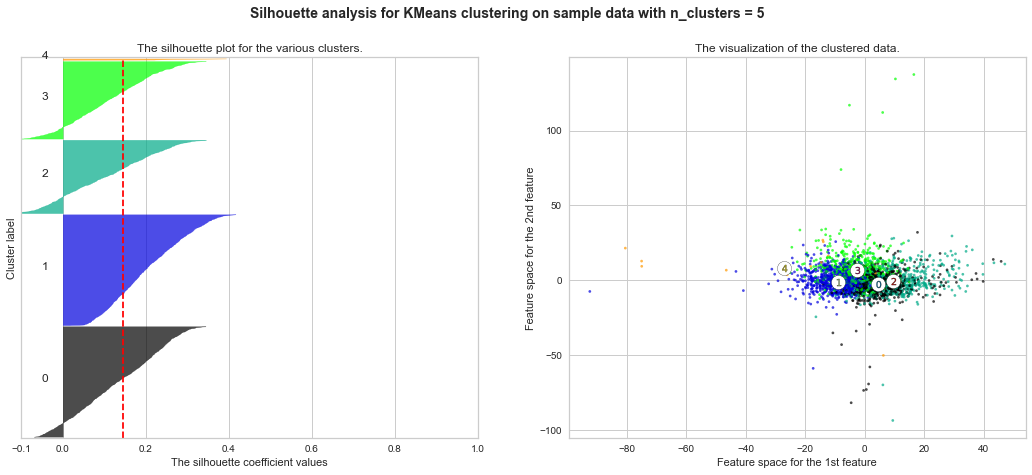

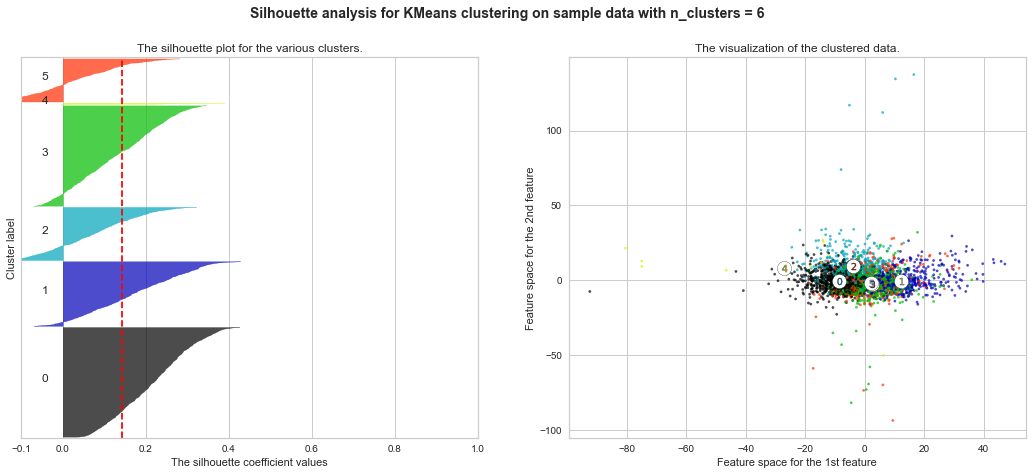

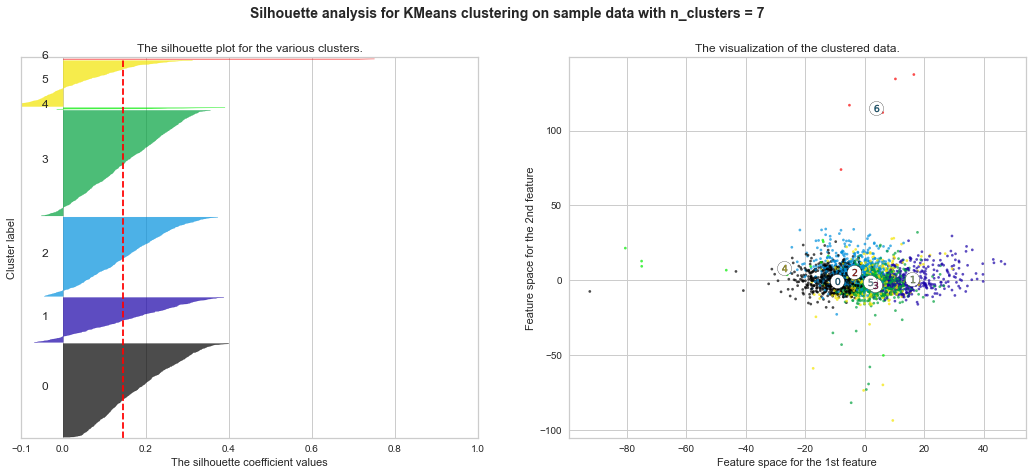

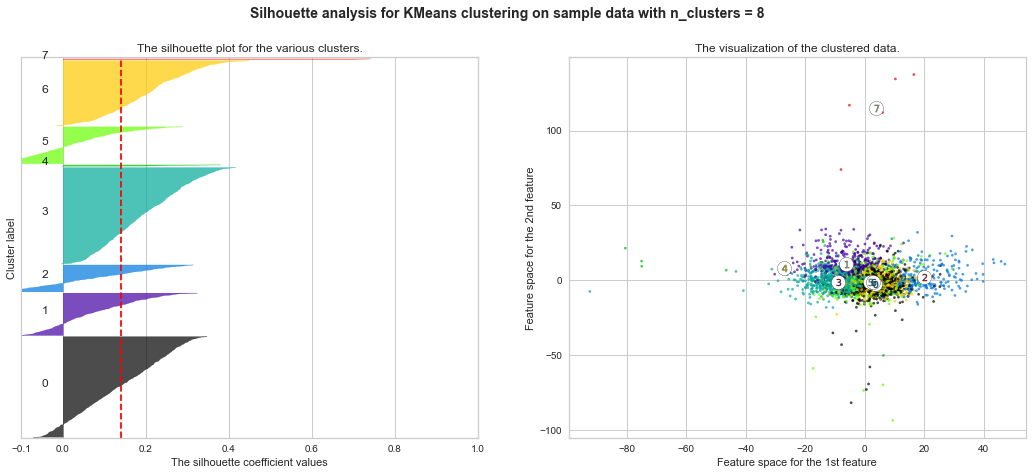

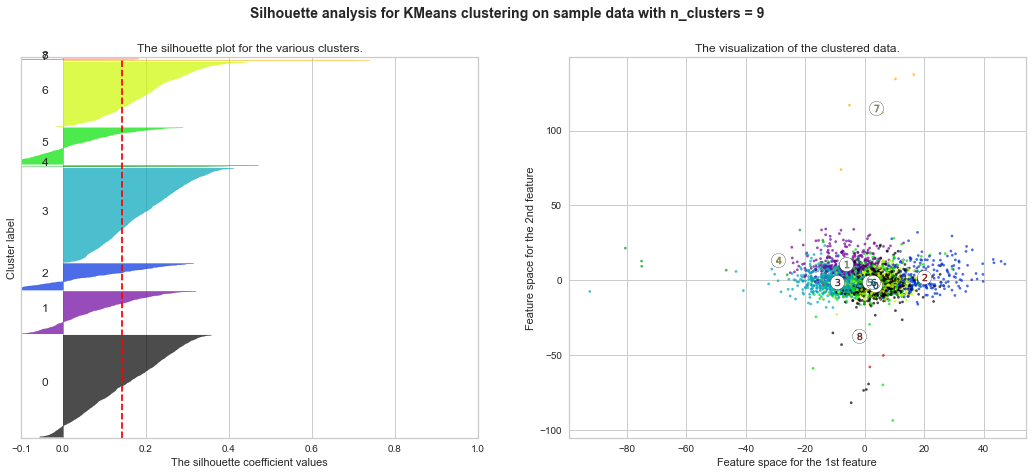

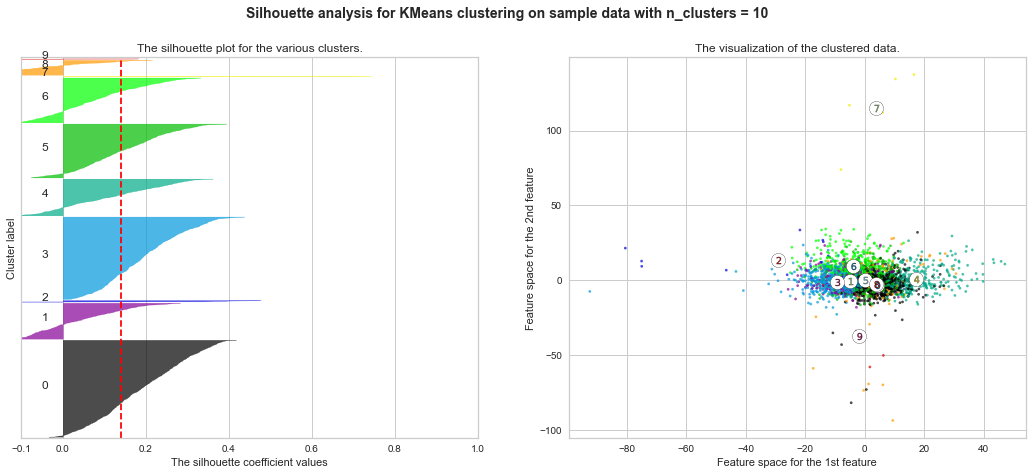

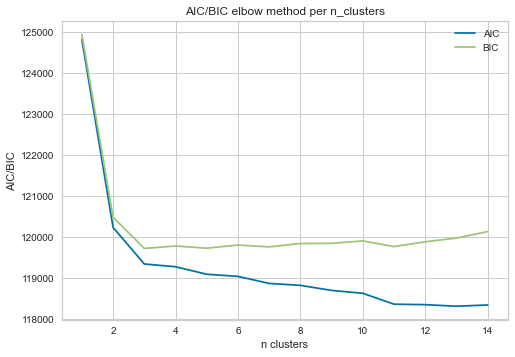

In [39]:
k_means_elbow_viz(RP_X)
k_means_silhouette(RP_X)
GMM_elbow(RP_X, y, range_n_clusters=range(1, 15))

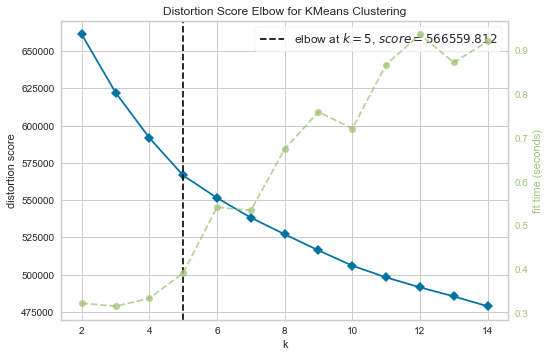

For n_clusters = 2 The average silhouette_score is : 0.08539345847142424
For n_clusters = 3 The average silhouette_score is : 0.06675061583183213
For n_clusters = 4 The average silhouette_score is : 0.0764156841208243
For n_clusters = 5 The average silhouette_score is : 0.08680644721117231
For n_clusters = 6 The average silhouette_score is : 0.08987255561374337
For n_clusters = 7 The average silhouette_score is : 0.08179534716117265
For n_clusters = 8 The average silhouette_score is : 0.082671548472698
For n_clusters = 9 The average silhouette_score is : 0.07329329918460124
For n_clusters = 10 The average silhouette_score is : 0.08076265867728376


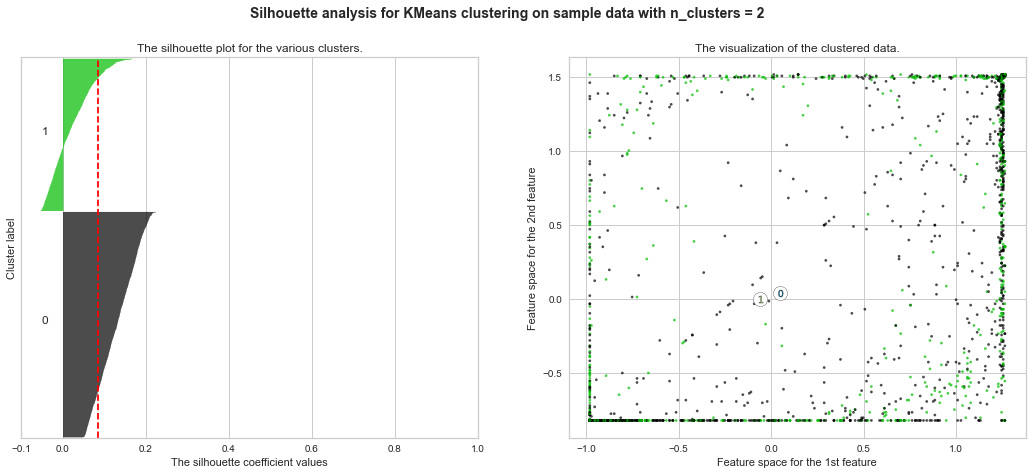

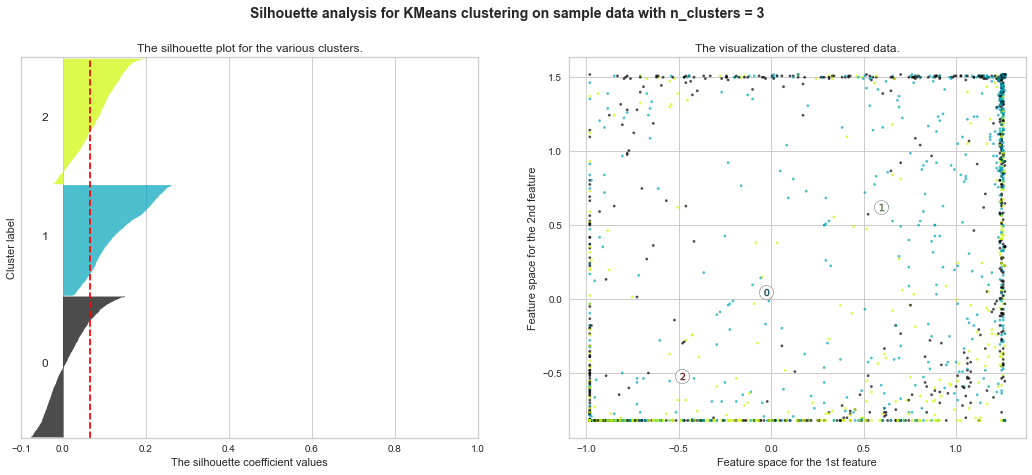

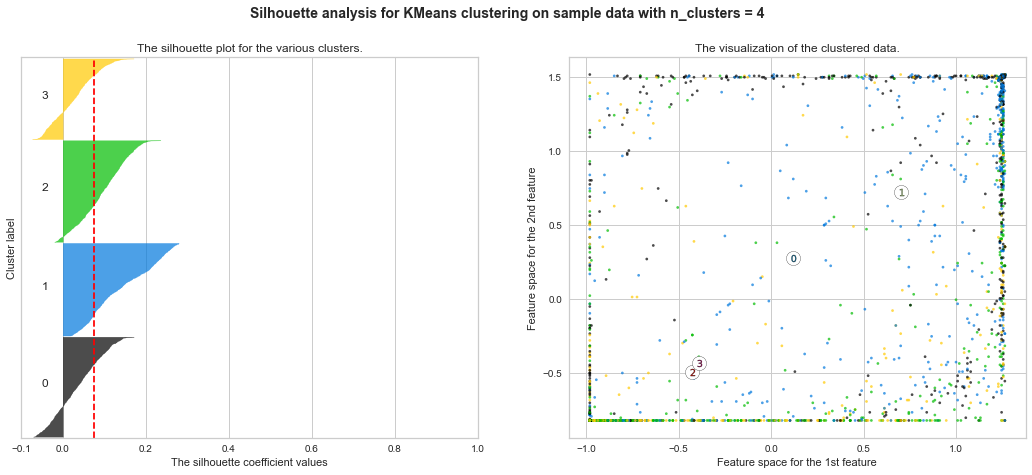

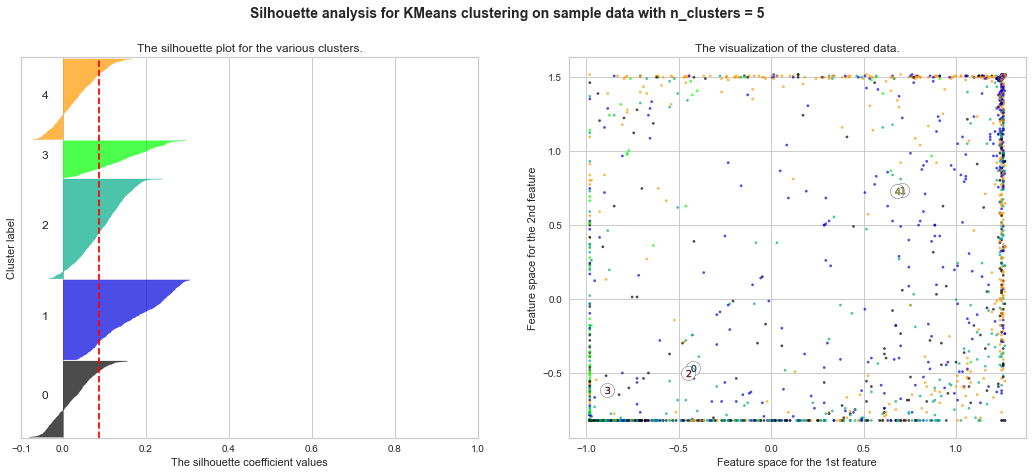

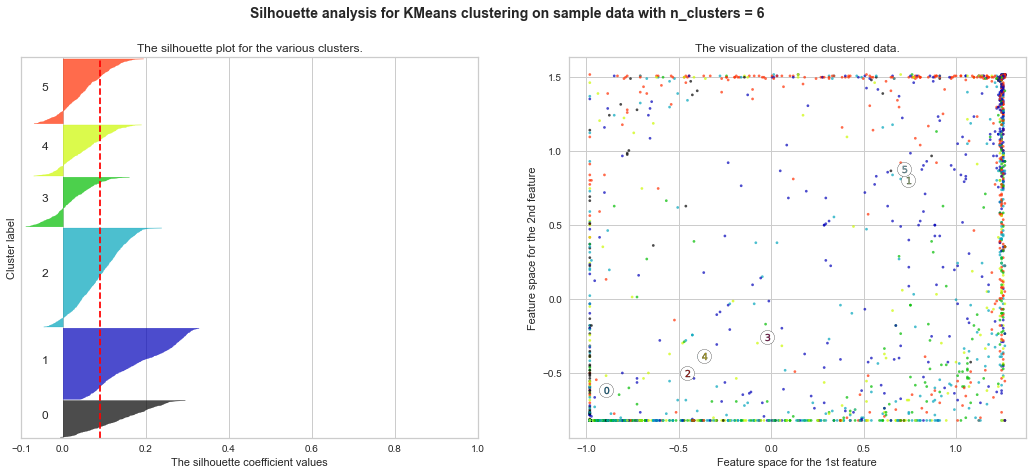

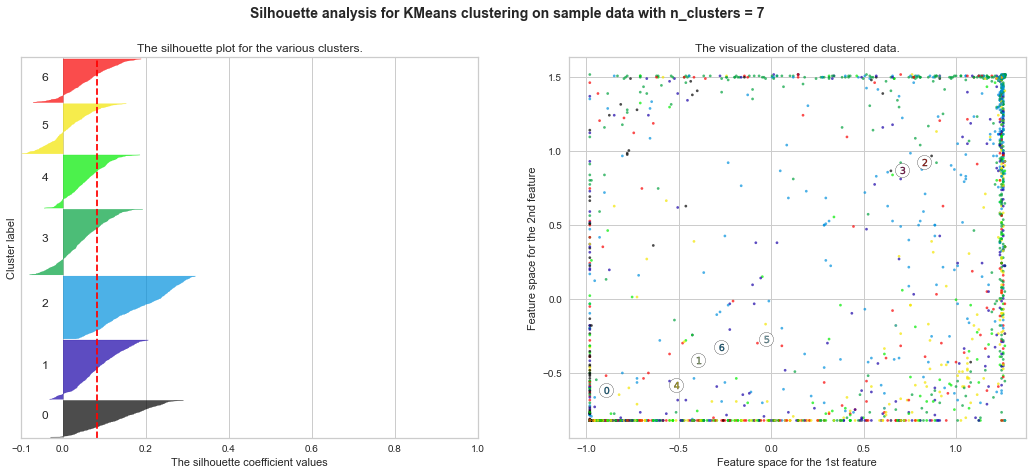

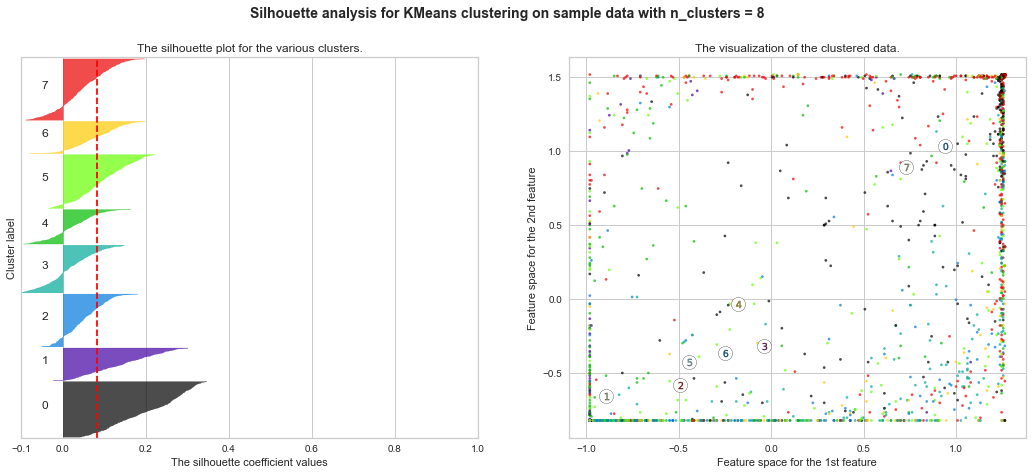

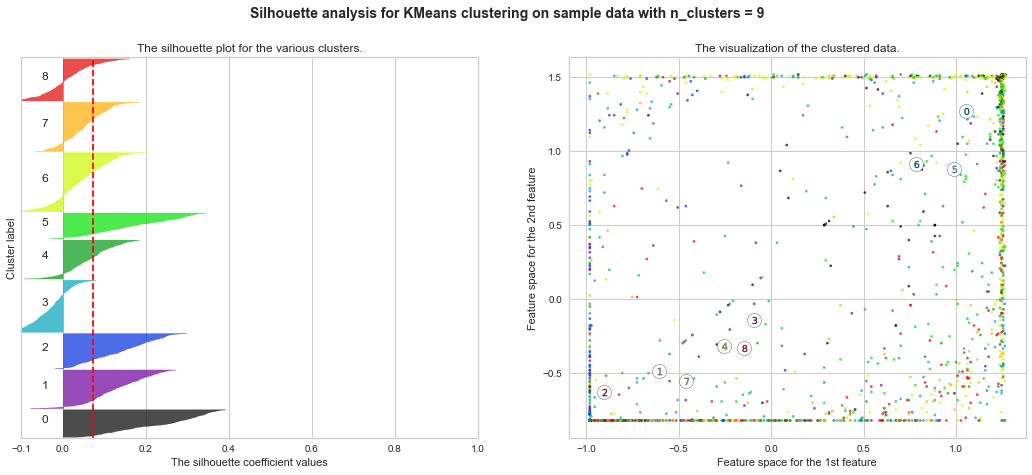

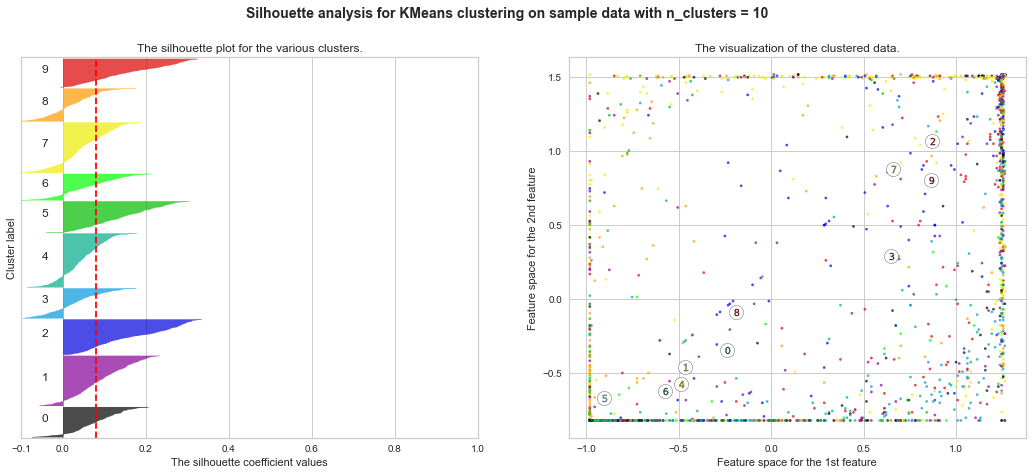

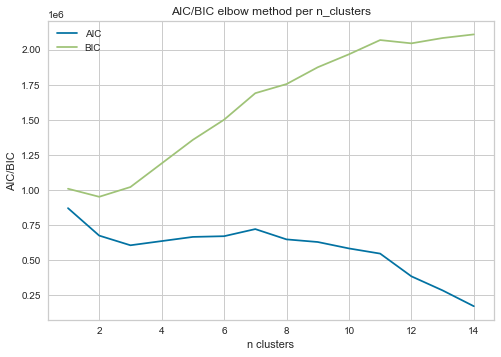

In [133]:
k_means_elbow_viz(RFC_X)
k_means_silhouette(RFC_X)
GMM_elbow(RFC_X, y, range_n_clusters=range(1, 15))

# Neural Network

In [145]:
print(X_train.shape)
print(pca_X_train.shape)

(3360, 784)
(3360, 228)


In [192]:

run_neural_network(X_train, y_train, X_test, y_test)

(3360, 784)


TypeError: The added layer must be an instance of class Layer. Found: Tensor("dense_16/Relu:0", shape=(None, 128), dtype=float32)

In [142]:
print(pca_X.shape)
run_neural_network(pca_X_train, y_train, pca_X_test, y_test)

(3360, 233)
(3360, 228)


ValueError: Input 0 of layer conv2d_24 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: [None, 228]

In [160]:
nearest_perfect_square(228)

NameError: name 'ceil_integer_distance' is not defined

In [161]:
from sklearn.neural_network import MLPClassifier
nnet = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=13)
nnet.fit(X_train, y_train)  
#data_train_pred = data_nn.predict(data)
#float(sum(data_train_pred == labels))/float(len(labels))
#data_test_pred = data_nn.predict(data_test) # data_test = x_test
#float(sum(data_test_pred == labels_test))/float(len(labels_test))

c:\users\fuers\anaconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=13,
              solver='lbfgs')

In [162]:
mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, random_state=1,
                    learning_rate_init=.1)
mlp.fit(X_train, y_train)

Iteration 1, loss = 0.84475944
Iteration 2, loss = 0.24760596
Iteration 3, loss = 0.12838223
Iteration 4, loss = 0.07630454
Iteration 5, loss = 0.04762263
Iteration 6, loss = 0.02883239
Iteration 7, loss = 0.02022971
Iteration 8, loss = 0.01406676
Iteration 9, loss = 0.01059145
Iteration 10, loss = 0.00869895


c:\users\fuers\anaconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(hidden_layer_sizes=(50,), learning_rate_init=0.1, max_iter=10,
              random_state=1, solver='sgd', verbose=10)

In [163]:
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

Training set score: 1.000000
Test set score: 0.920238


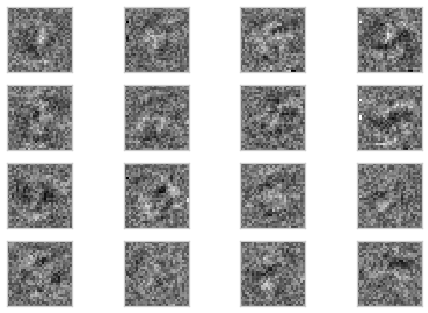

In [164]:
fig, axes = plt.subplots(4, 4)
vmin, vmax = mlp.coefs_[0].min(), mlp.coefs_[0].max()
for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

In [167]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


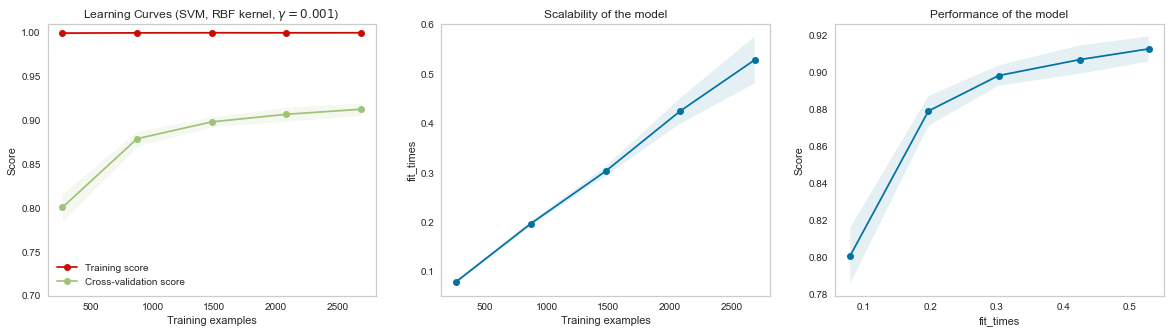

In [173]:
title = r"Learning Curves Base Classifier"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, random_state=1,
                    learning_rate_init=.1)
plot_learning_curve(estimator, title, X_train, y_train, ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)
plt.show()



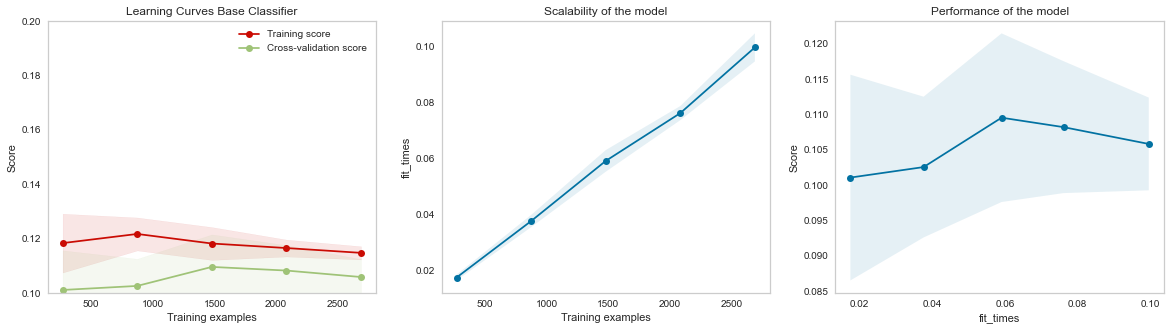

In [178]:
title = r"Learning Curves KMeans"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, random_state=1,
                    learning_rate_init=.1)
plot_learning_curve(estimator, title, kmeans_X_train, y_train, ylim=(0.1, 0.2),
                    cv=cv, n_jobs=4)
plt.show()

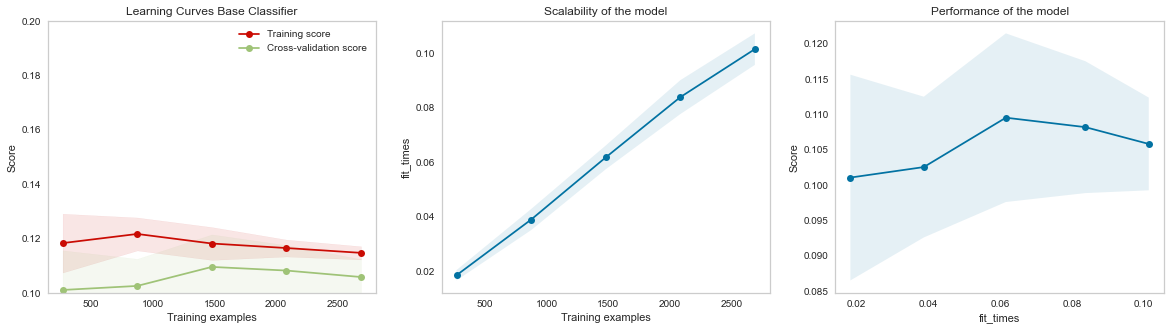

In [179]:
title = r"Learning Curves GMM"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, random_state=1,
                    learning_rate_init=.1)
plot_learning_curve(estimator, title, gmm_X_train, y_train, ylim=(0.1, 0.2),
                    cv=cv, n_jobs=4)
plt.show()

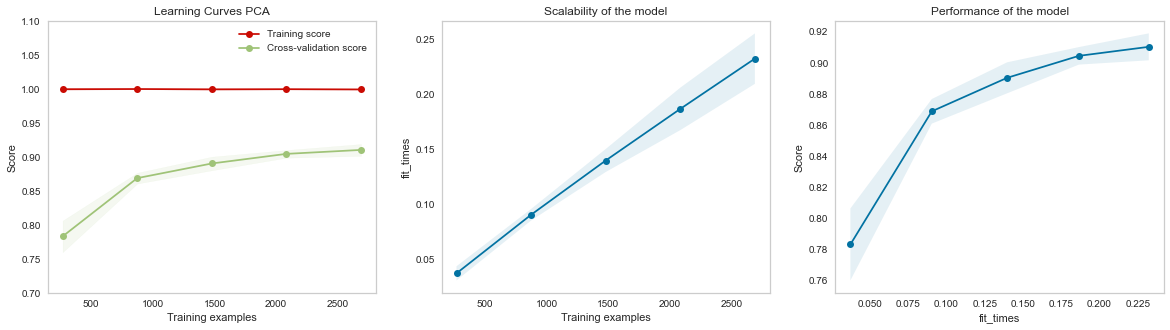

In [182]:
title = r"Learning Curves PCA"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, random_state=1,
                    learning_rate_init=.1)
plot_learning_curve(estimator, title, pca_X_train, y_train, ylim=(0.7, 1.1),
                    cv=cv, n_jobs=4)
plt.show()

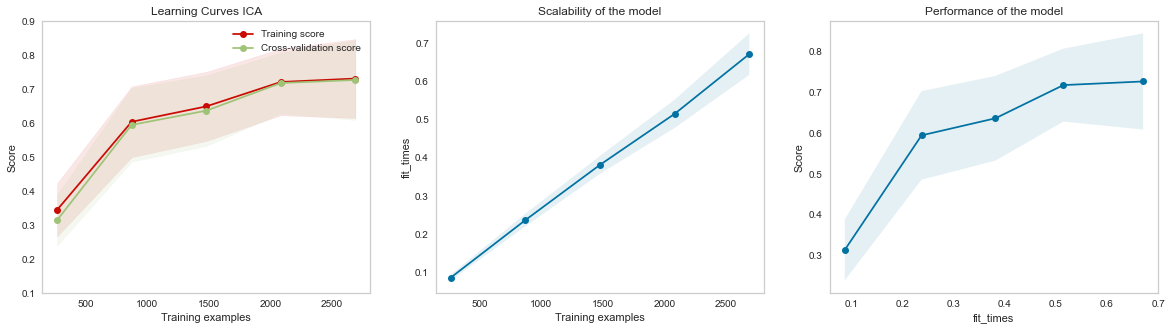

In [184]:
title = r"Learning Curves ICA"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, random_state=1,
                    learning_rate_init=.1)
plot_learning_curve(estimator, title, ica_X_train, y_train, ylim=(0.1, 0.9),
                    cv=cv, n_jobs=4)
plt.show()

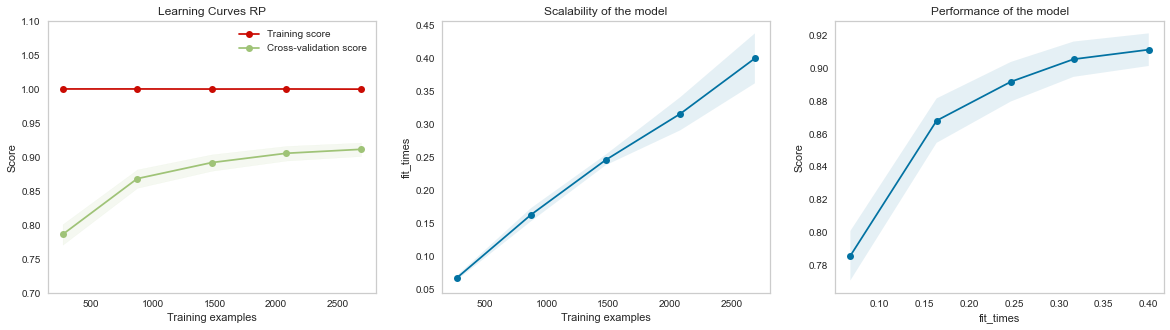

In [186]:
title = r"Learning Curves RP"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, random_state=1,
                    learning_rate_init=.1)
plot_learning_curve(estimator, title, RP_X_train, y_train, ylim=(0.7, 1.1),
                    cv=cv, n_jobs=4)
plt.show()

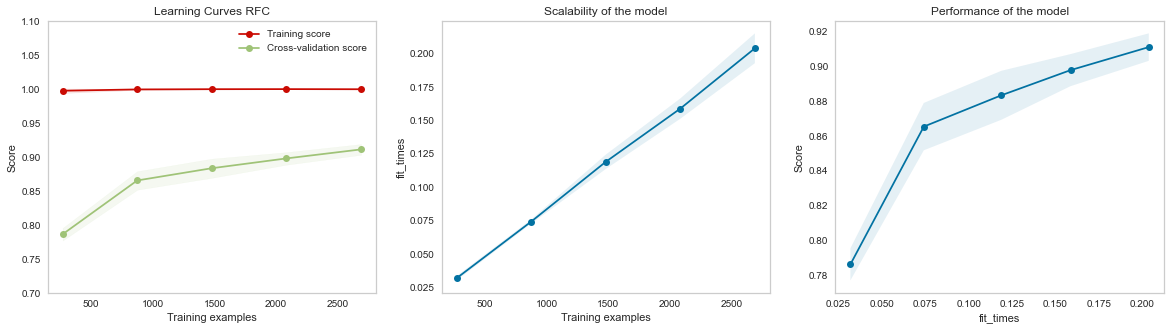

In [188]:
title = r"Learning Curves RFC"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, random_state=1,
                    learning_rate_init=.1)
plot_learning_curve(estimator, title, RFC_X_train, y_train, ylim=(0.7, 1.1),
                    cv=cv, n_jobs=4)
plt.show()